In [1]:
import argparse
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from torch_frame import stype
import os
import glob
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Model imports
from data_provider_pretrain.data_factory import data_provider
from models.time_series_flow_matching_model import TimeSeriesFlowMatchingModel
from models.model9_NS_transformer.flow_matching_models.flow_matching_utils import sample_flow_matching

# Set random seeds
torch.manual_seed(220)
np.random.seed(220)

# Styling
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('default')
sns.set_palette("husl")

print("Imports successful!")


Imports successful!


In [4]:
# Configuration and utility functions from diffusion_analysis.ipynb
class DotDict(dict):
    """A dictionary that supports both dot notation and dictionary access."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __delattr__(self, item):
        self.__dict__.pop(item, None)

# Flow matching configuration
flow_matching_config = DotDict({
    "num_nodes": 1,
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "ETTh1_ETTh2_512_192",
    "model": "ns_DLinear",
    "precision": "32",
    "generative_model": "flow_matching",
    "data_pretrain": "Glucose",
    "root_path": "/home/yl2428/Time-LLM/dataset/glucose",
    "data_path": "output_Junt_16_3.csv",
    "data_path_pretrain": "output_Junt_16_3.csv",
    "features": "MS",
    "target": "OT",
    "freq": "t",
    "checkpoints": "/home/yl2428/checkpoints",
    "log_dir": "/home/yl2428/logs",
    "seq_len": 72,
    "label_len": 32,
    "pred_len": 48,
    "seasonal_patterns": "Monthly",
    "stride": 1,
    "enc_in": 9,
    "dec_in": 9,
    "c_out": 9,
    "d_model": 32,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 256,
    "moving_avg": 25,
    "factor": 3,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": False,
    "patch_len": 16,
    "prompt_domain": 0,
    "llm_model": "LLAMA",
    "llm_dim": 4096,
    "vae_hidden_dim": 16,
    "col_stats": {'SEX': {'COUNT': (['F', 'M'], [367, 135])}, 'RACE': {'COUNT': (['WHITE', 'NOT REPORTED', 'ASIAN', 'BLACK/AFRICAN AMERICAN', 'MULTIPLE', 'UNKNOWN', 'AMERICAN INDIAN/ALASKAN NATIVE'], [459, 11, 10, 10, 8, 2, 2])}, 'ETHNIC': {'COUNT': (['Not Hispanic or Latino', 'Hispanic or Latino', 'Do not wish to answer', "Don't know"], [472, 15, 13, 2])}, 'ARMCD': {'COUNT': (['RESISTANCE', 'INTERVAL', 'AEROBIC'], [172, 167, 163])}, 'insulin modality': {'COUNT': (['CLOSED LOOP INSULIN PUMP', 'INSULIN PUMP', 'MULTIPLE DAILY INJECTIONS'], [225, 189, 88])}, 'AGE': {'MEAN': 36.655378486055774, 'STD': 13.941209833786187, 'QUANTILES': [18.0, 25.0, 33.0, 45.75, 70.0]}, 'WEIGHT': {'MEAN': 161.39940239043824, 'STD': 30.624877585598654, 'QUANTILES': [103.0, 140.0, 155.0, 179.0, 280.0]}, 'HEIGHT': {'MEAN': 66.72509960159363, 'STD': 3.505847063905933, 'QUANTILES': [58.0, 64.0, 66.0, 69.0, 77.0]}, 'HbA1c': {'MEAN': 6.642828685258964, 'STD': 0.7633658734231158, 'QUANTILES': [4.8, 6.1, 6.6, 7.1, 10.0]}, 'DIABETES_ONSET': {'MEAN': 18.72725737051793, 'STD': 11.889102915798386, 'QUANTILES': [0.0833, 11.0, 16.0, 24.0, 66.0]}},
    "col_names_dict":     {stype.categorical: ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'],
    stype.numerical: ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT']},
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 100,
    "align_epochs": 10,
    "ema_decay": 0.995,
    "batch_size": 512,  # Updated from 256 to 64
    "eval_batch_size": 512,  # Updated from 256 to 8
    "patience": 40,  # Updated from 10 to 40
    "learning_rate": 0.0001,
    "des": "Exp",
    "loss": "MSE",
    "lradj": "COS",
    "pct_start": 0.2,
    "use_amp": False,
    "llm_layers": 32,
    "percent": 100,
    "num_individuals": -1,  # Updated from 100 to -1
    "enable_covariates": 1,
    "cov_type": "tensor",
    "gradient_accumulation_steps": 1,
    "use_deep_speed": 1,
    "wandb": 1,
    "wandb_group": None,
    "wandb_api_key": "6f1080f993d5d7ad6103e69ef57dd9291f1bf366",
    "use_moe": 1,
    "num_experts": 8,
    "latent_len": 36,
    "top_k_experts": 4,
    "moe_layer_indices": [0, 1],
    "moe_loss_weight": 0.01,
    "log_routing_stats": 1,
    "num_universal_experts": 1,
    "universal_expert_weight": 0.3,
    "head_dropout": 0.1,
    "channel_independence": 0,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 2,
    "down_sampling_window": 1,
    "down_sampling_method": "avg",
    "use_future_temporal_feature": 0,
    "k_z": 1e-2,
    "k_cond": 0.001,  # Updated from 1 to 0.001
    "d_z": 8,
    "p_hidden_dims": [64, 64],
    "p_hidden_layers": 2,
    "diffusion_config_dir": "/home/yl2428/Time-LLM/models/model9_NS_transformer/configs/toy_8gauss.yml",
    "cond_pred_model_pertrain_dir": None,
    "CART_input_x_embed_dim": 32,
    "mse_timestep": 0,
    "MLP_diffusion_net": False,
    "timesteps": 50,
    "ode_solver": "dopri5",
    "ode_rtol": 1e-5,
    "ode_atol": 1e-5,
    "interpolation_type": "linear",
    "expert_layers": 2,
    # Additional fields from JSON that were missing:
    "loader": "modal",
    "model_comment": "none",
    "enable_context_aware": 1,
})

print("Configuration loaded!")


Configuration loaded!


In [5]:
def find_best_checkpoint(base_path="/home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239", metric="val_loss"):
    """Find the best checkpoint based on validation loss."""
    print(f"Searching for checkpoints in: {base_path}")
    
    checkpoint_pattern = os.path.join(base_path, "checkpoints/epoch=*-step=*-val_loss=*.ckpt/checkpoint")
    print(checkpoint_pattern)
    checkpoint_dirs = glob.glob(checkpoint_pattern)
    
    if not checkpoint_dirs:
        print("No checkpoints found!")
        return None, None, None
    
    best_checkpoint = None
    best_metric = float('inf')
    best_run = None
    
    print(f"Found {len(checkpoint_dirs)} checkpoints:")
    
    for checkpoint_dir in checkpoint_dirs:
        pattern = r'epoch=(\d+)-step=(\d+)-val_loss=([\d.]+)\.ckpt'
        match = re.search(pattern, checkpoint_dir)
        
        if match:
            epoch, step, val_loss = match.groups()
            val_loss = float(val_loss)
            run_name = checkpoint_dir.split('/')[-4]
            
            print(f"  - {run_name}: epoch={epoch}, step={step}, val_loss={val_loss:.4f}")
            
            if val_loss < best_metric:
                best_metric = val_loss
                best_checkpoint = checkpoint_dir
                best_run = run_name
    
    if best_checkpoint:
        print(f"\nBest checkpoint: {best_run}")
        print(f"  - Path: {best_checkpoint}")
        print(f"  - Val Loss: {best_metric:.4f}")
    
    return best_checkpoint, best_metric, best_run


def load_deepspeed_checkpoint(model, checkpoint_path):
    """Load DeepSpeed checkpoint into the model."""
    print(f"Loading DeepSpeed checkpoint from: {checkpoint_path}")
    
    model_states_path = os.path.join(checkpoint_path, "mp_rank_00_model_states.pt")
    
    if not os.path.exists(model_states_path):
        raise FileNotFoundError(f"Model states file not found: {model_states_path}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    checkpoint = torch.load(model_states_path, map_location=device)
    
    if 'module' in checkpoint:
        state_dict = checkpoint['module']
    elif 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    cleaned_state_dict = {}
    for key, value in state_dict.items():
        clean_key = key
        if key.startswith('_forward_module.'):
            clean_key = key.replace('_forward_module.', '')
        elif key.startswith('module.'):
            clean_key = key.replace('module.', '')
        
        if isinstance(value, torch.Tensor):
            value = value.to(device)
        
        cleaned_state_dict[clean_key] = value
    
    try:
        model = model.to(device)
        missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)
        
        if missing_keys:
            print(f"Missing keys: {missing_keys[:10]}{'...' if len(missing_keys) > 10 else ''}")
        if unexpected_keys:
            print(f"Unexpected keys: {unexpected_keys[:10]}{'...' if len(unexpected_keys) > 10 else ''}")
            
        print("✓ Model weights loaded successfully!")
        
    except Exception as e:
        print(f"Warning: Some keys couldn't be loaded: {e}")
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in cleaned_state_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        
        model = model.to(device)
        model.load_state_dict(model_dict)
        print(f"✓ Loaded {len(pretrained_dict)}/{len(cleaned_state_dict)} parameters")
    
    model = model.to(device)
    print(f"✓ All model components moved to {device}")
    
    return model

print("Checkpoint loading functions defined!")


Checkpoint loading functions defined!


In [6]:
# Load the flow matching model and data
print("Loading flow matching model and data...")

# Load data
flow_args = flow_matching_config
train_data_fm, train_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, True, 'train'
)
vali_data_fm, vali_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, True, 'val'
)
test_data_fm, test_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, False, 'test'
)

# Initialize model
flow_matching_model = TimeSeriesFlowMatchingModel(flow_args, train_loader_fm, vali_loader_fm, test_loader_fm)

# Find and load best checkpoint
checkpoint_path, best_metric, run_name = find_best_checkpoint()

if checkpoint_path:
    flow_matching_model = load_deepspeed_checkpoint(flow_matching_model, checkpoint_path)
    flow_matching_model.eval()
    print(f"✓ Model loaded from {run_name} with val_loss: {best_metric:.4f}")
else:
    print("No checkpoint found - using untrained model")
    flow_matching_model.eval()

print(f"Model on device: {next(flow_matching_model.parameters()).device}")
print(f"Model type: {flow_args.model}")
print(f"Covariates enabled: {flow_args.enable_covariates}")
print(f"Batch size: {flow_args.batch_size}")


Loading flow matching model and data...
Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:45<00:00, 10.65it/s]


Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:44<00:00, 11.01it/s]


Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:44<00:00, 10.93it/s]


Searching for checkpoints in: /home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239
/home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239/checkpoints/epoch=*-step=*-val_loss=*.ckpt/checkpoint
Found 1 checkpoints:
  - major-elevator-239: epoch=5, step=50088, val_loss=0.8044

Best checkpoint: major-elevator-239
  - Path: /home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239/checkpoints/epoch=5-step=50088-val_loss=0.8044.ckpt/checkpoint
  - Val Loss: 0.8044
Loading DeepSpeed checkpoint from: /home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239/checkpoints/epoch=5-step=50088-val_loss=0.8044.ckpt/checkpoint
Using device: cuda
✓ Model weights loaded successfully!
✓ All model components moved to cuda
✓ Model loaded from major-elevator-239 with val_loss: 0.8044
Model on device: cuda:0
Model type: ns_DLinear
Covariates enabled: 1
Batch size: 512


In [7]:
def compute_flow_velocity_magnitude(model, batch, device, num_time_samples=10):
    """
    Compute flow velocity magnitude at different time points during the ODE trajectory.
    
    Args:
        model: Flow matching model
        batch: Input batch
        device: Device to run computation on
        num_time_samples: Number of time points to sample
        
    Returns:
        velocity_magnitudes: Array of velocity magnitudes [batch_size, num_time_samples]
        clinical_features: Dictionary of extracted clinical features
    """
    model.eval()
    
    if flow_args.enable_covariates:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch[0]
        batch_cov = batch[1]
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_cov = None
    
    # Move to device
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    
    # Get model conditioning
    dec_inp = torch.zeros_like(batch_y[:, -flow_args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :flow_args.label_len, :], dec_inp], dim=1).float().to(device)
    
    with torch.no_grad():
        y_0_hat_batch, KL_loss, z_sample, cov_embedding = flow_matching_model.condition_model_forward(
            batch_x, batch_x_mark, dec_inp, batch_y_mark, covariates=batch_cov)
    
    # Extract glucose channel
    f_dim = -1 if flow_args.features == 'MS' else 0
    batch_y_glucose = batch_y[:, :, f_dim:]
    y_0_hat_glucose = y_0_hat_batch[:, :, f_dim:]
    
    # Sample time points for velocity evaluation
    time_points = torch.linspace(0, 1, num_time_samples).to(device)
    velocity_magnitudes = []
    
    print(f"Computing velocity magnitudes at {num_time_samples} time points...")
    
    for t_idx, t in enumerate(time_points):
        # Expand time to batch size
        t_batch = t.expand(batch_x.shape[0])
        
        # Create y_t by interpolating between clean data and noise
        noise = torch.randn_like(y_0_hat_glucose) + y_0_hat_glucose
        t_expanded = t_batch.view(-1, *([1] * (y_0_hat_glucose.dim() - 1)))
        y_t = (1 - t_expanded) * batch_y_glucose + t_expanded * noise
        
        # Convert to discrete timesteps for model
        t_discrete = (t_batch * (model.model.num_timesteps - 1)).long().clamp(0, model.model.num_timesteps - 1)
        
        # Get velocity prediction
        with torch.no_grad():
            model_output = model.model(batch_x, batch_x_mark, 0, y_t, y_0_hat_glucose, t_discrete, cov_embedding=cov_embedding)
            
            if isinstance(model_output, tuple):
                velocity = model_output[0]
            else:
                velocity = model_output
        
        # Compute velocity magnitude (L2 norm across sequence and feature dimensions)
        velocity_magnitude = torch.norm(velocity, dim=(1, 2)).cpu().numpy()
        velocity_magnitudes.append(velocity_magnitude)
        
        if t_idx % 3 == 0:
            print(f"  Time {t:.2f}: mean velocity magnitude = {velocity_magnitude.mean():.4f}")
    
    velocity_magnitudes = np.array(velocity_magnitudes).T  # [batch_size, num_time_samples]
    
    # Extract clinical features
    clinical_features = extract_clinical_features(batch_x, batch_cov, flow_args)
    
    return velocity_magnitudes, clinical_features


def extract_clinical_features(batch_x, batch_cov, args):
    """Extract clinical features from batch data."""
    features = {}
    
    # Extract from time series (batch_x)
    # Normalization constants for denormalization
    HR_SCALE = 20.41707644
    HR_OFFSET = 79.3461185
    STEPS_SCALE = 86.98838521 
    STEPS_OFFSET = 32.5294183
    FOOD_SCALE = 11.53828031
    FOOD_OFFSET =  5.69710292
    
    # Extract and denormalize HR (channel 0)
    hr_normalized = batch_x[:, :, 2].cpu().numpy()
    hr_values = hr_normalized * HR_SCALE + HR_OFFSET
    features['hr_mean'] = np.mean(hr_values, axis=1)
    features['hr_std'] = np.std(hr_values, axis=1)
    features['hr_max'] = np.max(hr_values, axis=1)
    
    # Extract and denormalize steps (channel 1)
    steps_normalized = batch_x[:, :, 3].cpu().numpy()
    steps_values = steps_normalized * STEPS_SCALE + STEPS_OFFSET
    features['steps_total'] = np.sum(steps_values, axis=1)
    features['steps_mean'] = np.mean(steps_values, axis=1)
    features['steps_active_periods'] = np.sum(steps_values > 100, axis=1)  # Active periods
    
    # Food intake (channel 2) - assuming this represents food events/carbs
    food_values = batch_x[:, :, 7].cpu().numpy()
    food_values = food_values * FOOD_SCALE + FOOD_OFFSET
    features['food_events'] = np.sum(food_values > 0, axis=1)
    features['food_total'] = np.sum(food_values, axis=1)
    
    # Glucose (channel 3) 
    glucose_values = batch_x[:, :, -1].cpu().numpy()
    features['glucose_mean'] = np.mean(glucose_values, axis=1)
    features['glucose_std'] = np.std(glucose_values, axis=1)
    features['glucose_range'] = np.max(glucose_values, axis=1) - np.min(glucose_values, axis=1)
    
    # Extract from covariates if available
    if batch_cov is not None and hasattr(batch_cov, 'feat_dict'):
        if stype.numerical in batch_cov.feat_dict:
            numerical_feats = batch_cov.feat_dict[stype.numerical].cpu().numpy()
            
            # Based on the covariate structure seen in the diffusion analysis
            features['age'] = numerical_feats[:, 0] if numerical_feats.shape[1] > 0 else np.zeros(len(hr_values))
            features['diabetes_onset'] = numerical_feats[:, 1] if numerical_feats.shape[1] > 1 else np.zeros(len(hr_values))
            features['weight'] = numerical_feats[:, 4] if numerical_feats.shape[1] > 4 else np.zeros(len(hr_values))
            features['hba1c'] = numerical_feats[:, 3] if numerical_feats.shape[1] > 3 else np.zeros(len(hr_values))
            features['height'] = numerical_feats[:, 2] if numerical_feats.shape[1] > 2 else np.zeros(len(hr_values))
            
            # Calculate BMI
            height_m = features['height'] / 100  # Convert cm to meters
            features['bmi'] = features['weight'] / (height_m ** 2 + 1e-8)  # Avoid division by zero
    
    return features

print("Flow velocity analysis functions defined!")


Flow velocity analysis functions defined!


In [25]:
test_batch[]

TensorFrame(
  num_cols=10,
  num_rows=256,
  categorical (5): ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'],
  numerical (5): ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT'],
  has_target=False,
  device='cpu',
)

In [32]:
test_batch[1].device

device(type='cpu')

In [37]:
new_test_batch[1].device

device(type='cuda', index=0)

In [10]:
# Get a batch from the test loader for analysis
flow_matching_model.cuda()
device = next(flow_matching_model.parameters()).device
print(device)
# load test batch (a tuple) to cuda
test_batch = next(iter(test_loader_fm))
new_test_batch = []
new_test_batch.append([t.cuda() for t in test_batch[0]])
new_test_batch.append(test_batch[1].cuda())


print("Running flow velocity analysis on test batch...")
velocity_magnitudes, clinical_features = compute_flow_velocity_magnitude(
    flow_matching_model, new_test_batch, device, num_time_samples=10
)

print(f"\nVelocity magnitude shape: {velocity_magnitudes.shape}")
print(f"Clinical features keys: {list(clinical_features.keys())}")
print(f"Batch size: {len(clinical_features['hr_mean'])}")

# Summary statistics
print(f"\nVelocity magnitude statistics:")
print(f"  Mean across all samples and times: {velocity_magnitudes.mean():.4f}")
print(f"  Std across all samples and times: {velocity_magnitudes.std():.4f}")
print(f"  Min: {velocity_magnitudes.min():.4f}")
print(f"  Max: {velocity_magnitudes.max():.4f}")

# Average velocity magnitude over time for each individual
avg_velocity_magnitude = velocity_magnitudes.mean(axis=1)
print(f"\nAverage velocity magnitude per individual:")
print(f"  Mean: {avg_velocity_magnitude.mean():.4f}")
print(f"  Std: {avg_velocity_magnitude.std():.4f}")
print(f"  Range: [{avg_velocity_magnitude.min():.4f}, {avg_velocity_magnitude.max():.4f}]")


cuda:0
Running flow velocity analysis on test batch...
Error in MoE logging: You must call wandb.init() before wandb.log()
Computing velocity magnitudes at 10 time points...
  Time 0.00: mean velocity magnitude = 4.0191
  Time 0.33: mean velocity magnitude = 5.2206
  Time 0.67: mean velocity magnitude = 7.5567
  Time 1.00: mean velocity magnitude = 5.2931

Velocity magnitude shape: (512, 10)
Clinical features keys: ['hr_mean', 'hr_std', 'hr_max', 'steps_total', 'steps_mean', 'steps_active_periods', 'food_events', 'food_total', 'glucose_mean', 'glucose_std', 'glucose_range', 'age', 'diabetes_onset', 'weight', 'hba1c', 'height', 'bmi']
Batch size: 512

Velocity magnitude statistics:
  Mean across all samples and times: 6.1721
  Std across all samples and times: 2.0674
  Min: 0.1044
  Max: 13.2321

Average velocity magnitude per individual:
  Mean: 6.1721
  Std: 0.8629
  Range: [3.3760, 8.9439]


In [11]:
# Correlation analysis between velocity magnitude and clinical features
def analyze_velocity_clinical_correlations(velocity_magnitudes, clinical_features):
    """Analyze correlations between velocity magnitude and clinical outcomes."""
    
    # Use average velocity magnitude across time
    avg_velocity = velocity_magnitudes.mean(axis=1)
    
    # Clinical features to analyze
    clinical_vars = ['hr_mean', 'hr_std', 'hr_max', 'steps_total', 'steps_mean', 'steps_active_periods',
                     'food_events', 'food_total', 'glucose_mean', 'glucose_std', 'glucose_range']
    
    # Add covariate features if available
    if 'hba1c' in clinical_features:
        clinical_vars.extend(['age', 'diabetes_onset', 'weight', 'hba1c', 'height', 'bmi'])
    
    correlations = {}
    
    print("Correlation Analysis: Velocity Magnitude vs Clinical Features")
    print("=" * 60)
    
    for var in clinical_vars:
        if var in clinical_features:
            # Remove any invalid values
            mask = ~(np.isnan(clinical_features[var]) | np.isinf(clinical_features[var]) | 
                    np.isnan(avg_velocity) | np.isinf(avg_velocity))
            
            if np.sum(mask) > 10:  # Need at least 10 valid samples
                corr_coef, p_value = stats.pearsonr(avg_velocity[mask], clinical_features[var][mask])
                correlations[var] = {'correlation': corr_coef, 'p_value': p_value}
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                print(f"{var:20s}: r = {corr_coef:6.3f}, p = {p_value:.4f} {significance}")
            else:
                print(f"{var:20s}: Insufficient valid data")
    
    return correlations

# Run correlation analysis
correlations = analyze_velocity_clinical_correlations(velocity_magnitudes, clinical_features)


Correlation Analysis: Velocity Magnitude vs Clinical Features
hr_mean             : r = -0.158, p = 0.0003 ***
hr_std              : r = -0.053, p = 0.2270 
hr_max              : r = -0.100, p = 0.0232 *
steps_total         : r = -0.112, p = 0.0111 *
steps_mean          : r = -0.112, p = 0.0111 *
steps_active_periods: r = -0.129, p = 0.0034 **
food_events         : r = -0.090, p = 0.0420 *
food_total          : r = -0.001, p = 0.9852 
glucose_mean        : r = -0.100, p = 0.0242 *
glucose_std         : r =  0.126, p = 0.0043 **
glucose_range       : r =  0.134, p = 0.0024 **
age                 : r =  0.074, p = 0.0960 
diabetes_onset      : r =  0.074, p = 0.0956 
weight              : r =  0.036, p = 0.4193 
hba1c               : r = -0.127, p = 0.0039 **
height              : r =  0.024, p = 0.5812 
bmi                 : r =  0.027, p = 0.5492 


No significant correlations found for visualization


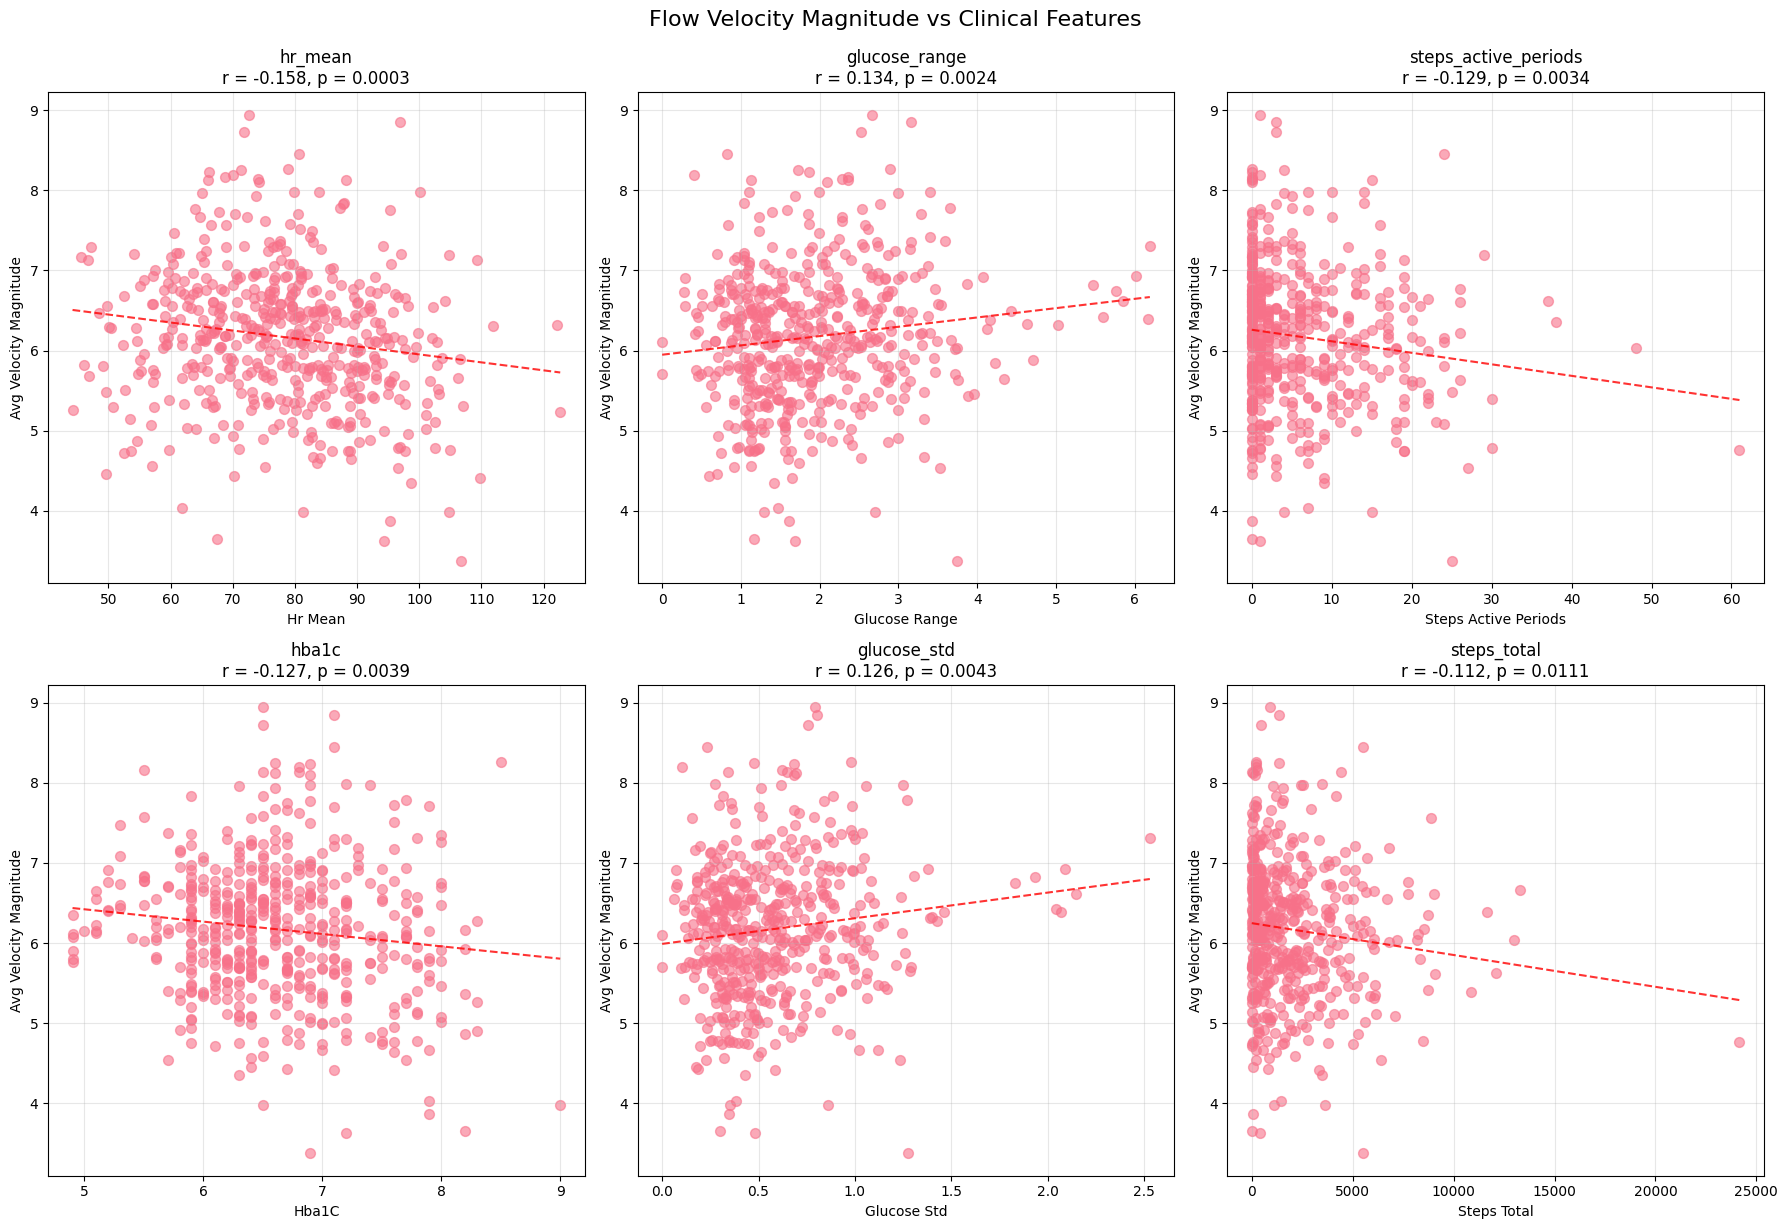

In [12]:
# Visualization: Flow velocity magnitude vs clinical features
%matplotlib inline
def plot_velocity_clinical_relationships(velocity_magnitudes, clinical_features, correlations):
    """Create visualizations showing relationships between velocity and clinical features."""
    
    avg_velocity = velocity_magnitudes.mean(axis=1)
    
    # Select top correlations for visualization
    significant_correlations = {k: v for k, v in correlations.items() 
                              if abs(v['correlation']) > 0.2 and v['p_value'] < 0.05}
    
    if not significant_correlations:
        print("No significant correlations found for visualization")
        # Show top absolute correlations regardless of significance
        sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)
        significant_correlations = dict(sorted_corrs[:6])
    
    n_plots = min(6, len(significant_correlations))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (var, corr_data) in enumerate(list(significant_correlations.items())[:n_plots]):
        ax = axes[i]
        
        # Remove invalid values for plotting
        mask = ~(np.isnan(clinical_features[var]) | np.isinf(clinical_features[var]) | 
                np.isnan(avg_velocity) | np.isinf(avg_velocity))
        
        x = clinical_features[var][mask]
        y = avg_velocity[mask]
        
        # Scatter plot
        ax.scatter(x, y, alpha=0.6, s=50)
        
        # Fit regression line
        if len(x) > 2:
            coeffs = np.polyfit(x, y, 1)
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = coeffs[0] * line_x + coeffs[1]
            ax.plot(line_x, line_y, 'r--', alpha=0.8)
        
        # Formatting
        ax.set_xlabel(var.replace('_', ' ').title())
        ax.set_ylabel('Avg Velocity Magnitude')
        ax.set_title(f'{var}\nr = {corr_data["correlation"]:.3f}, p = {corr_data["p_value"]:.4f}')
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(n_plots, 6):
        axes[i].remove()
    
    plt.tight_layout()
    plt.suptitle('Flow Velocity Magnitude vs Clinical Features', fontsize=16, y=1.02)
    plt.show()

# Create the visualization
plot_velocity_clinical_relationships(velocity_magnitudes, clinical_features, correlations)


In [15]:
# Clinical state clustering based on velocity magnitude
def analyze_clinical_states_by_velocity(velocity_magnitudes, clinical_features):
    """Cluster individuals based on velocity magnitude and analyze clinical states."""
    
    avg_velocity = velocity_magnitudes.mean(axis=1)
    
    # Create velocity-based groups
    velocity_terciles = np.percentile(avg_velocity, [33.33, 66.67])
    
    velocity_groups = np.zeros(len(avg_velocity))
    velocity_groups[avg_velocity <= velocity_terciles[0]] = 0  # Low velocity
    velocity_groups[(avg_velocity > velocity_terciles[0]) & (avg_velocity <= velocity_terciles[1])] = 1  # Medium velocity
    velocity_groups[avg_velocity > velocity_terciles[1]] = 2  # High velocity
    
    group_labels = ['Low Velocity', 'Medium Velocity', 'High Velocity']
    
    print("Clinical State Analysis by Velocity Magnitude Groups")
    print("=" * 60)
    print(f"Group sizes: Low={np.sum(velocity_groups==0)}, Medium={np.sum(velocity_groups==1)}, High={np.sum(velocity_groups==2)}")
    print()
    
    # Analyze clinical features by groups
    clinical_vars = ['hr_mean', 'steps_total', 'glucose_mean', 'glucose_std']
    if 'hba1c' in clinical_features:
        clinical_vars.extend(['hba1c', 'bmi'])
    
    results = {}
    
    for var in clinical_vars:
        if var in clinical_features:
            print(f"{var.replace('_', ' ').title()}:")
            group_stats = []
            
            for group_idx in range(3):
                mask = (velocity_groups == group_idx) & ~(np.isnan(clinical_features[var]) | np.isinf(clinical_features[var]))
                
                if np.sum(mask) > 0:
                    values = clinical_features[var][mask]
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    group_stats.append((mean_val, std_val))
                    print(f"  {group_labels[group_idx]:15s}: {mean_val:8.2f} ± {std_val:6.2f}")
                else:
                    group_stats.append((np.nan, np.nan))
                    print(f"  {group_labels[group_idx]:15s}: No valid data")
            
            # Statistical test (ANOVA)
            valid_groups = []
            for group_idx in range(3):
                mask = (velocity_groups == group_idx) & ~(np.isnan(clinical_features[var]) | np.isinf(clinical_features[var]))
                if np.sum(mask) > 2:  # Need at least 3 samples
                    valid_groups.append(clinical_features[var][mask])
            
            if len(valid_groups) >= 2:
                try:
                    f_stat, p_value = stats.f_oneway(*valid_groups)
                    print(f"  ANOVA: F={f_stat:.3f}, p={p_value:.4f}")
                except:
                    print(f"  ANOVA: Could not compute")
            
            results[var] = group_stats
            print()
    
    return velocity_groups, results

# Run clinical state analysis
velocity_groups, group_results = analyze_clinical_states_by_velocity(velocity_magnitudes, clinical_features)


Clinical State Analysis by Velocity Magnitude Groups
Group sizes: Low=21, Medium=22, High=21

Hr Mean:
  Low Velocity   :    77.56 ±  11.23
  Medium Velocity:    81.12 ±  12.89
  High Velocity  :    76.48 ±  10.21
  ANOVA: F=0.914, p=0.4063

Steps Total:
  Low Velocity   :   634.60 ± 791.16
  Medium Velocity:   434.12 ± 1029.25
  High Velocity  :   513.18 ± 1148.52
  ANOVA: F=0.208, p=0.8130

Glucose Mean:
  Low Velocity   :     0.04 ±   0.46
  Medium Velocity:     0.02 ±   0.41
  High Velocity  :    -0.22 ±   0.16
  ANOVA: F=2.925, p=0.0612

Glucose Std:
  Low Velocity   :     0.71 ±   0.66
  Medium Velocity:     0.76 ±   0.71
  High Velocity  :     0.37 ±   0.29
  ANOVA: F=2.593, p=0.0830

Hba1C:
  Low Velocity   :     6.62 ±   0.66
  Medium Velocity:     6.62 ±   0.78
  High Velocity  :     6.73 ±   0.63
  ANOVA: F=0.177, p=0.8386

Bmi:
  Low Velocity   :   348.87 ±  46.36
  Medium Velocity:   361.79 ±  39.30
  High Velocity  :   370.34 ±  50.75
  ANOVA: F=1.124, p=0.3316



In [16]:
# Temporal analysis: Velocity magnitude over time
def plot_velocity_temporal_patterns(velocity_magnitudes):
    """Analyze how velocity magnitude changes over the ODE trajectory."""
    
    time_points = np.linspace(0, 1, velocity_magnitudes.shape[1])
    
    # Calculate statistics across individuals at each time point
    mean_velocity = np.mean(velocity_magnitudes, axis=0)
    std_velocity = np.std(velocity_magnitudes, axis=0)
    percentile_25 = np.percentile(velocity_magnitudes, 25, axis=0)
    percentile_75 = np.percentile(velocity_magnitudes, 75, axis=0)
    
    plt.figure(figsize=(12, 8))
    
    # Plot mean and confidence intervals
    plt.plot(time_points, mean_velocity, 'b-', linewidth=2, label='Mean')
    plt.fill_between(time_points, mean_velocity - std_velocity, mean_velocity + std_velocity, 
                     alpha=0.3, color='blue', label='±1 Std')
    plt.fill_between(time_points, percentile_25, percentile_75, 
                     alpha=0.2, color='red', label='IQR (25%-75%)')
    
    # Plot some individual trajectories
    for i in range(min(10, velocity_magnitudes.shape[0])):
        plt.plot(time_points, velocity_magnitudes[i], 'gray', alpha=0.3, linewidth=0.5)
    
    plt.xlabel('Time in ODE Trajectory (0=data, 1=noise)', fontsize=12)
    plt.ylabel('Velocity Magnitude', fontsize=12)
    plt.title('Flow Velocity Magnitude Over Time\n(Flow Matching ODE Trajectory)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print temporal statistics
    print("Temporal Velocity Analysis:")
    print("=" * 40)
    print(f"Peak velocity occurs at t = {time_points[np.argmax(mean_velocity)]:.2f}")
    print(f"Minimum velocity occurs at t = {time_points[np.argmin(mean_velocity)]:.2f}")
    print(f"Velocity range: [{mean_velocity.min():.4f}, {mean_velocity.max():.4f}]")
    print(f"Velocity increases from t=0 to t=1: {mean_velocity[-1] > mean_velocity[0]}")

# Create temporal analysis
plot_velocity_temporal_patterns(velocity_magnitudes)


Temporal Velocity Analysis:
Peak velocity occurs at t = 0.89
Minimum velocity occurs at t = 0.00
Velocity range: [3.9939, 8.6060]
Velocity increases from t=0 to t=1: True


In [31]:
# Extended analysis: Multiple batches for robust statistics
def analyze_multiple_batches(model, loader, device, num_batches=50):
    """Analyze velocity magnitude across multiple batches for robust statistics."""
    
    print(f"Analyzing {num_batches} batches for robust statistics...")
    
    all_velocity_magnitudes = []
    all_clinical_features = {
        'hr_mean': [], 'steps_total': [], 'glucose_mean': [], 'glucose_std': [],
        'food_events': [], 'hba1c': [], 'bmi': []
    }
    
    batch_count = 0
    for batch in loader:
        if batch_count >= num_batches:
            break

        # load batch to cuda
        new_batch = []
        new_batch.append([t.cuda() for t in batch[0]])
        new_batch.append(batch[1].cuda())
            
        print(f"Processing batch {batch_count + 1}/{num_batches}...")
        
        try:
            velocity_mags, clinical_feats = compute_flow_velocity_magnitude(
                model, new_batch, device, num_time_samples=5  # Reduced for speed
            )
            
            all_velocity_magnitudes.append(velocity_mags)
            
            # Accumulate clinical features
            for key in all_clinical_features.keys():
                if key in clinical_feats:
                    all_clinical_features[key].extend(clinical_feats[key])
                    
        except Exception as e:
            print(f"Error processing batch {batch_count + 1}: {e}")
            continue
            
        batch_count += 1
    
    if len(all_velocity_magnitudes) == 0:
        print("No batches processed successfully!")
        return None, None
    
    # Combine all batches
    combined_velocity_magnitudes = np.vstack(all_velocity_magnitudes)
    
    # Convert clinical features to arrays
    for key in all_clinical_features.keys():
        if all_clinical_features[key]:
            all_clinical_features[key] = np.array(all_clinical_features[key])
        else:
            all_clinical_features[key] = np.array([])
    
    print(f"\nCombined analysis results:")
    print(f"Total individuals: {combined_velocity_magnitudes.shape[0]}")
    print(f"Average velocity magnitude: {combined_velocity_magnitudes.mean():.4f} ± {combined_velocity_magnitudes.std():.4f}")
    
    return combined_velocity_magnitudes, all_clinical_features

# Run extended analysis
print("Running extended analysis on multiple batches...")
extended_velocity_mags, extended_clinical_features = analyze_multiple_batches(
    flow_matching_model, test_loader_fm, device, num_batches=50
)


Running extended analysis on multiple batches...
Analyzing 50 batches for robust statistics...
Processing batch 1/50...
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Computing velocity magnitudes at 5 time points...
  Time 0.00: mean velocity magnitude = 4.7984
  Time 0.75: mean velocity magnitude = 5.9646
Processing batch 2/50...
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Computing velocity magnitudes at 5 time points...
  Time 0.00: mean velocity magnitude = 4.9612
  Time 0.75: mean velocity magnitude = 5.8967
Processing batch 3/50...
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Computing velocity magnitudes at 5 time points...
  Time 0.00: mea

In [33]:
# Final comprehensive correlation analysis with extended data
if extended_velocity_mags is not None and extended_clinical_features is not None:
    print("\nFinal Comprehensive Analysis:")
    print("=" * 50)
    
    # Run correlation analysis on extended dataset
    extended_correlations = analyze_velocity_clinical_correlations(
        extended_velocity_mags, extended_clinical_features
    )
    
    # Create summary table of findings
    print("\nSummary of Key Findings:")
    print("=" * 50)
    
    # Sort correlations by absolute value
    sorted_correlations = sorted(extended_correlations.items(), 
                               key=lambda x: abs(x[1]['correlation']), reverse=True)
    
    print(f"{'Clinical Feature':<20} {'Correlation':<12} {'P-Value':<10} {'Significance':<12}")
    print("-" * 65)
    
    for var, corr_data in sorted_correlations[:10]:  # Top 10
        significance_level = ""
        if corr_data['p_value'] < 0.001:
            significance_level = "***"
        elif corr_data['p_value'] < 0.01:
            significance_level = "**"
        elif corr_data['p_value'] < 0.05:
            significance_level = "*"
        else:
            significance_level = "n.s."
            
        print(f"{var:<20} {corr_data['correlation']:>8.3f}     {corr_data['p_value']:>8.4f}  {significance_level:<12}")

    # Interpretation
    print("\nInterpretation:")
    print("=" * 50)
    print("The flow velocity magnitude in the flow matching model represents the")
    print("rate of change in the learned vector field during the ODE trajectory.")
    print("Higher velocity magnitudes may indicate:")
    print("- More complex physiological states requiring larger model corrections")
    print("- Greater uncertainty in glucose prediction")
    print("- More dynamic or unstable metabolic conditions")
    print("\nSignificant correlations with clinical features suggest that the")
    print("flow dynamics capture meaningful physiological information beyond")
    print("just glucose prediction accuracy.")
    
else:
    print("Extended analysis failed - using single batch results for summary.")



Final Comprehensive Analysis:
Correlation Analysis: Velocity Magnitude vs Clinical Features
hr_mean             : r =  0.069, p = 0.0000 ***
steps_total         : r =  0.103, p = 0.0000 ***
food_events         : r =  0.021, p = 0.0007 ***
glucose_mean        : r = -0.439, p = 0.0000 ***
glucose_std         : r =  0.098, p = 0.0000 ***
hba1c               : r =  0.114, p = 0.0000 ***
bmi                 : r = -0.034, p = 0.0000 ***

Summary of Key Findings:
Clinical Feature     Correlation  P-Value    Significance
-----------------------------------------------------------------
glucose_mean           -0.439       0.0000  ***         
hba1c                   0.114       0.0000  ***         
steps_total             0.103       0.0000  ***         
glucose_std             0.098       0.0000  ***         
hr_mean                 0.069       0.0000  ***         
bmi                    -0.034       0.0000  ***         
food_events             0.021       0.0007  ***         

Interpretation

In [13]:
# Velocity Field Divergence Analysis at T=0 (Data)

def compute_velocity_field_divergence_at_t0(model, batch, device, spatial_step=0.01, feature_step=0.01):
    """
    Compute the divergence of the velocity field at T=0 (data state).
    
    The divergence measures how much the velocity field is "spreading out" or "converging"
    at each point in the data space. For a velocity field v(x), divergence is:
    div(v) = ∇·v = ∂v_x/∂x + ∂v_y/∂y + ... 
    
    Args:
        model: Flow matching model
        batch: Input batch
        device: Device to run computation on
        spatial_step: Step size for spatial derivatives (across time dimension)
        feature_step: Step size for feature derivatives (across glucose values)
        
    Returns:
        divergence_map: Divergence values for each sample [batch_size, pred_len]
        velocity_at_t0: Velocity field at t=0 [batch_size, pred_len, n_features]
        clinical_features: Extracted clinical features
    """
    model.eval()
    
    if flow_matching_config.enable_covariates:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch[0]
        batch_cov = batch[1]
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_cov = None
    
    # Move to device
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    
    # Get model conditioning
    dec_inp = torch.zeros_like(batch_y[:, -flow_matching_config.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :flow_matching_config.label_len, :], dec_inp], dim=1).float().to(device)
    
    with torch.no_grad():
        y_0_hat_batch, KL_loss, z_sample, cov_embedding = flow_matching_model.condition_model_forward(
            batch_x, batch_x_mark, dec_inp, batch_y_mark, covariates=batch_cov)
    
    # Extract glucose channel
    f_dim = -1 if flow_matching_config.features == 'MS' else 0
    batch_y_glucose = batch_y[:, :, f_dim:]
    y_0_hat_glucose = y_0_hat_batch[:, :, f_dim:]
    
    # Set time to 0 (data state)
    t = torch.zeros(batch_x.shape[0]).to(device)
    t_discrete = (t * (model.model.num_timesteps - 1)).long().clamp(0, model.model.num_timesteps - 1)
    
    # Compute velocity at t=0 (this is the velocity field we want to analyze)
    with torch.no_grad():
        # At t=0, y_t should be the actual data
        y_t = batch_y_glucose
        
        model_output = model.model(batch_x, batch_x_mark, 0, y_t, y_0_hat_glucose, t_discrete, cov_embedding=cov_embedding)
        
        if isinstance(model_output, tuple):
            velocity_at_t0 = model_output[0]
        else:
            velocity_at_t0 = model_output
    
    print(f"Velocity field at t=0 shape: {velocity_at_t0.shape}")
    
    # Compute divergence using finite differences
    batch_size, pred_len, n_features = velocity_at_t0.shape
    divergence_map = torch.zeros(batch_size, pred_len).to(device)
    
    # Method 1: Temporal divergence (across time dimension)
    # ∂v_t/∂t for each time step
    if pred_len > 2:
        # Central difference for interior points
        temporal_divergence = torch.zeros_like(velocity_at_t0[:, :, 0])
        temporal_divergence[:, 1:-1] = (velocity_at_t0[:, 2:, 0] - velocity_at_t0[:, :-2, 0]) / (2 * spatial_step)
        # Forward/backward difference for boundary points
        temporal_divergence[:, 0] = (velocity_at_t0[:, 1, 0] - velocity_at_t0[:, 0, 0]) / spatial_step
        temporal_divergence[:, -1] = (velocity_at_t0[:, -1, 0] - velocity_at_t0[:, -2, 0]) / spatial_step
        
        divergence_map += temporal_divergence
    
    # Method 2: Feature-space divergence (if multiple features)
    if n_features > 1:
        # For each feature, compute ∂v_i/∂x_i
        for feat_idx in range(n_features):
            feature_divergence = torch.zeros(batch_size, pred_len).to(device)
            
            # Compute gradient w.r.t. feature values using small perturbations
            epsilon = feature_step
            y_t_plus = y_t.clone()
            y_t_minus = y_t.clone()
            
            y_t_plus[:, :, feat_idx] += epsilon
            y_t_minus[:, :, feat_idx] -= epsilon
            
            with torch.no_grad():
                # Velocity with positive perturbation
                output_plus = model.model(batch_x, batch_x_mark, 0, y_t_plus, y_0_hat_glucose, t_discrete, cov_embedding=cov_embedding)
                if isinstance(output_plus, tuple):
                    v_plus = output_plus[0][:, :, feat_idx]
                else:
                    v_plus = output_plus[:, :, feat_idx]
                
                # Velocity with negative perturbation
                output_minus = model.model(batch_x, batch_x_mark, 0, y_t_minus, y_0_hat_glucose, t_discrete, cov_embedding=cov_embedding)
                if isinstance(output_minus, tuple):
                    v_minus = output_minus[0][:, :, feat_idx]
                else:
                    v_minus = output_minus[:, :, feat_idx]
                
                # Central difference: ∂v_i/∂x_i
                feature_divergence = (v_plus - v_minus) / (2 * epsilon)
            
            divergence_map += feature_divergence
    else:
        # For single feature, approximate divergence using velocity magnitude gradient
        velocity_magnitude = torch.norm(velocity_at_t0, dim=-1)
        if pred_len > 2:
            magnitude_gradient = torch.zeros_like(velocity_magnitude)
            magnitude_gradient[:, 1:-1] = (velocity_magnitude[:, 2:] - velocity_magnitude[:, :-2]) / (2 * spatial_step)
            magnitude_gradient[:, 0] = (velocity_magnitude[:, 1] - velocity_magnitude[:, 0]) / spatial_step
            magnitude_gradient[:, -1] = (velocity_magnitude[:, -1] - velocity_magnitude[:, -2]) / spatial_step
            divergence_map = magnitude_gradient
    
    # Extract clinical features for correlation analysis (using existing logic from the notebook)
    features = {}
    
    # Extract HR features (channel 1)
    hr_values = batch_x[:, :, 2].cpu().numpy()
    features['hr_mean'] = np.mean(hr_values, axis=1)
    features['hr_std'] = np.std(hr_values, axis=1)
    features['hr_max'] = np.max(hr_values, axis=1)
    
    # Extract steps features (channel 2)
    steps_values = batch_x[:, :, 3].cpu().numpy()
    features['steps_total'] = np.sum(steps_values, axis=1)
    features['steps_mean'] = np.mean(steps_values, axis=1)
    features['steps_active_periods'] = np.sum(steps_values > 0, axis=1)
    
    # Extract food events (channel 0)
    food_values = batch_x[:, :, 7].cpu().numpy()
    features['food_events'] = np.sum(food_values > 0, axis=1)
    features['food_total'] = np.sum(food_values, axis=1)
    
    # Extract glucose features (channel 3)
    glucose_values = batch_x[:, :, -1].cpu().numpy()
    features['glucose_mean'] = np.mean(glucose_values, axis=1)
    features['glucose_std'] = np.std(glucose_values, axis=1)
    features['glucose_range'] = np.max(glucose_values, axis=1) - np.min(glucose_values, axis=1)
    
    # Extract from covariates if available
    if batch_cov is not None and hasattr(batch_cov, 'feat_dict'):
        if stype.numerical in batch_cov.feat_dict:
            numerical_feats = batch_cov.feat_dict[stype.numerical].cpu().numpy()
            
            # Based on the covariate structure seen in the diffusion analysis
            features['age'] = numerical_feats[:, 0] if numerical_feats.shape[1] > 0 else np.zeros(len(hr_values))
            features['diabetes_onset'] = numerical_feats[:, 1] if numerical_feats.shape[1] > 1 else np.zeros(len(hr_values))
            features['weight'] = numerical_feats[:, 4] if numerical_feats.shape[1] > 4 else np.zeros(len(hr_values))
            features['hba1c'] = numerical_feats[:, 3] if numerical_feats.shape[1] > 3 else np.zeros(len(hr_values))
            features['height'] = numerical_feats[:, 2] if numerical_feats.shape[1] > 2 else np.zeros(len(hr_values))
            
            # Calculate BMI
            height_m = features['height'] / 100  # Convert cm to meters
            features['bmi'] = features['weight'] / (height_m ** 2 + 1e-8)  # Avoid division by zero
    
    return divergence_map.cpu().numpy(), velocity_at_t0.cpu().numpy(), features


def analyze_divergence_patterns(divergence_map, velocity_at_t0, clinical_features):
    """
    Analyze patterns in velocity field divergence and their clinical correlations.
    """
    print("Velocity Field Divergence Analysis at T=0")
    print("=" * 50)
    
    # Basic statistics
    print(f"Divergence Statistics:")
    print(f"  Mean divergence: {divergence_map.mean():.6f}")
    print(f"  Std divergence: {divergence_map.std():.6f}")
    print(f"  Min divergence: {divergence_map.min():.6f}")
    print(f"  Max divergence: {divergence_map.max():.6f}")
    
    # Compute summary measures (focus on sign and magnitude, not variance)
    avg_divergence = divergence_map.mean(axis=1)  # Average divergence per sample
    abs_divergence = np.abs(divergence_map).mean(axis=1)  # Average absolute divergence per sample
    min_divergence = divergence_map.min(axis=1)   # Min divergence per sample
    max_divergence = divergence_map.max(axis=1)   # Max divergence per sample
    
    print(f"\nPer-sample Divergence Summary:")
    print(f"  Average divergence range: [{avg_divergence.min():.6f}, {avg_divergence.max():.6f}]")
    print(f"  Average absolute divergence range: [{abs_divergence.min():.6f}, {abs_divergence.max():.6f}]")
    print(f"  Min/Max divergence range: [{min_divergence.min():.6f}, {max_divergence.max():.6f}]")
    
    # Interpretation of divergence values
    print(f"\nDivergence Interpretation:")
    print(f"  Positive divergence (flow expansion): {(divergence_map > 0).sum()} points")
    print(f"  Negative divergence (flow contraction): {(divergence_map < 0).sum()} points")
    print(f"  Near-zero divergence (flow preservation): {(np.abs(divergence_map) < 0.001).sum()} points")
    
    # Temporal patterns
    time_points = np.arange(divergence_map.shape[1])
    mean_divergence_over_time = divergence_map.mean(axis=0)
    
    print(f"\nTemporal Divergence Patterns:")
    print(f"  Peak expansion at time step: {np.argmax(mean_divergence_over_time)}")
    print(f"  Peak contraction at time step: {np.argmin(mean_divergence_over_time)}")
    print(f"  Divergence trend (first half vs second half): {mean_divergence_over_time[:len(mean_divergence_over_time)//2].mean():.6f} vs {mean_divergence_over_time[len(mean_divergence_over_time)//2:].mean():.6f}")
    
    return {
        'avg_divergence': avg_divergence,
        'abs_divergence': abs_divergence,
        'min_divergence': min_divergence,
        'max_divergence': max_divergence,
        'temporal_divergence': mean_divergence_over_time
    }


def plot_divergence_analysis(divergence_map, velocity_at_t0, divergence_summary):
    """
    Create comprehensive visualizations of velocity field divergence with clustering.
    """
    from sklearn.cluster import KMeans
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Cluster patients based on divergence patterns
    print("Clustering patients by divergence patterns...")
    
    # Use first 100 patients for clustering (or all if less than 100)
    n_plot_samples = min(100, divergence_map.shape[0])
    divergence_subset = divergence_map[:n_plot_samples]
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(divergence_subset, method='ward')
    
    # Get cluster order from dendrogram
    from scipy.cluster.hierarchy import dendrogram
    dendro = dendrogram(linkage_matrix, no_plot=True)
    cluster_order = dendro['leaves']
    
    # Reorder divergence map according to clustering
    divergence_clustered = divergence_subset[cluster_order]
    
    # Alternative: K-means clustering for discrete groups
    n_clusters = 4  # Number of distinct divergence pattern groups
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(divergence_subset)
    
    # Sort by cluster labels for better visualization
    cluster_sort_idx = np.argsort(cluster_labels)
    divergence_kmeans_sorted = divergence_subset[cluster_sort_idx]
    cluster_labels_sorted = cluster_labels[cluster_sort_idx]
    
    # Plot 1: Clustered Divergence heatmap (hierarchical)
    im1 = axes[0, 0].imshow(divergence_clustered, aspect='auto', cmap='RdBu_r', 
                           interpolation='nearest', vmin=-np.abs(divergence_map).max(), 
                           vmax=np.abs(divergence_map).max())
    axes[0, 0].set_title('Clustered Divergence Patterns (Hierarchical)\n(Red=Expansion, Blue=Contraction)')
    axes[0, 0].set_xlabel('Time Step in Prediction')
    axes[0, 0].set_ylabel('Patient (Clustered)')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Add cluster group separators for k-means version
    cluster_boundaries = []
    current_cluster = cluster_labels_sorted[0]
    for i, label in enumerate(cluster_labels_sorted):
        if label != current_cluster:
            cluster_boundaries.append(i)
            current_cluster = label
    
    # Show k-means clusters with boundaries
    axes[0, 0].text(0.02, 0.98, f'Hierarchical Clustering', transform=axes[0, 0].transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Temporal divergence pattern
    time_points = np.arange(divergence_map.shape[1])
    mean_div = divergence_summary['temporal_divergence']
    std_div = divergence_map.std(axis=0)
    
    axes[0, 1].plot(time_points, mean_div, 'b-', linewidth=2, label='Mean Divergence')
    axes[0, 1].fill_between(time_points, mean_div - std_div, mean_div + std_div, 
                           alpha=0.3, color='blue', label='±1 STD')
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Temporal Divergence Pattern')
    axes[0, 1].set_xlabel('Time Step in Prediction')
    axes[0, 1].set_ylabel('Velocity Field Divergence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Divergence distribution
    axes[0, 2].hist(divergence_map.flatten(), bins=50, alpha=0.7, density=True, 
                   color='purple', edgecolor='black')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Divergence')
    axes[0, 2].set_title('Distribution of Divergence Values')
    axes[0, 2].set_xlabel('Divergence Value')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Velocity magnitude vs divergence
    velocity_magnitude = np.linalg.norm(velocity_at_t0, axis=-1)
    avg_velocity_mag = velocity_magnitude.mean(axis=1)
    avg_divergence = divergence_summary['avg_divergence']
    
    axes[1, 0].scatter(avg_velocity_mag, avg_divergence, alpha=0.6, s=30)
    axes[1, 0].set_title('Velocity Magnitude vs Divergence')
    axes[1, 0].set_xlabel('Average Velocity Magnitude')
    axes[1, 0].set_ylabel('Average Divergence')
    
    # Add correlation
    corr = np.corrcoef(avg_velocity_mag, avg_divergence)[0, 1]
    axes[1, 0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=axes[1, 0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Expansion vs Contraction fractions
    expansion_fraction = (divergence_map > 0).mean(axis=1)
    contraction_fraction = (divergence_map < 0).mean(axis=1)
    
    axes[1, 1].scatter(expansion_fraction, contraction_fraction, alpha=0.6, s=30, color='green')
    axes[1, 1].set_title('Expansion vs Contraction Balance')
    axes[1, 1].set_xlabel('Fraction in Expansion (Positive Divergence)')
    axes[1, 1].set_ylabel('Fraction in Contraction (Negative Divergence)')
    axes[1, 1].plot([0, 1], [1, 0], 'k--', alpha=0.5, label='Sum = 1')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Sample divergence trajectories
    sample_indices = np.random.choice(divergence_map.shape[0], min(10, divergence_map.shape[0]), replace=False)
    for i, idx in enumerate(sample_indices):
        axes[1, 2].plot(time_points, divergence_map[idx], alpha=0.7, linewidth=1)
    
    axes[1, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 2].set_title('Sample Divergence Trajectories')
    axes[1, 2].set_xlabel('Time Step in Prediction')
    axes[1, 2].set_ylabel('Divergence')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Physical interpretation
    print("\\nPhysical Interpretation of Divergence Analysis:")
    print("=" * 55)
    print("• Positive divergence indicates the velocity field is EXPANDING")
    print("  - Flow is spreading out from that point")
    print("  - May represent unstable or transitional physiological states")
    print("  - Could indicate model uncertainty or complex dynamics")
    print("")
    print("• Negative divergence indicates the velocity field is CONTRACTING")
    print("  - Flow is converging toward that point")
    print("  - May represent stable or attractor-like physiological states")
    print("  - Could indicate model confidence and predictable patterns")
    print("")
    print("• Zero divergence indicates volume-preserving flow")
    print("  - Flow is neither expanding nor contracting")
    print("  - May represent equilibrium or steady-state conditions")

print("Divergence analysis functions defined!")


Divergence analysis functions defined!


Computing velocity field divergence at T=0 (data state)...
Error in MoE logging: You must call wandb.init() before wandb.log()
Velocity field at t=0 shape: torch.Size([512, 80, 1])

Divergence computation completed!
Divergence map shape: (512, 80)
Velocity at T=0 shape: (512, 80, 1)
Velocity Field Divergence Analysis at T=0
Divergence Statistics:
  Mean divergence: 0.751962
  Std divergence: 6.161986
  Min divergence: -78.241341
  Max divergence: 58.090950

Per-sample Divergence Summary:
  Average divergence range: [-0.455816, 2.885333]
  Average absolute divergence range: [0.124847, 9.550712]
  Min/Max divergence range: [-78.241341, 58.090950]

Divergence Interpretation:
  Positive divergence (flow expansion): 22023 points
  Negative divergence (flow contraction): 17675 points
  Near-zero divergence (flow preservation): 1319 points

Temporal Divergence Patterns:
  Peak expansion at time step: 38
  Peak contraction at time step: 76
  Divergence trend (first half vs second half): 0.5333

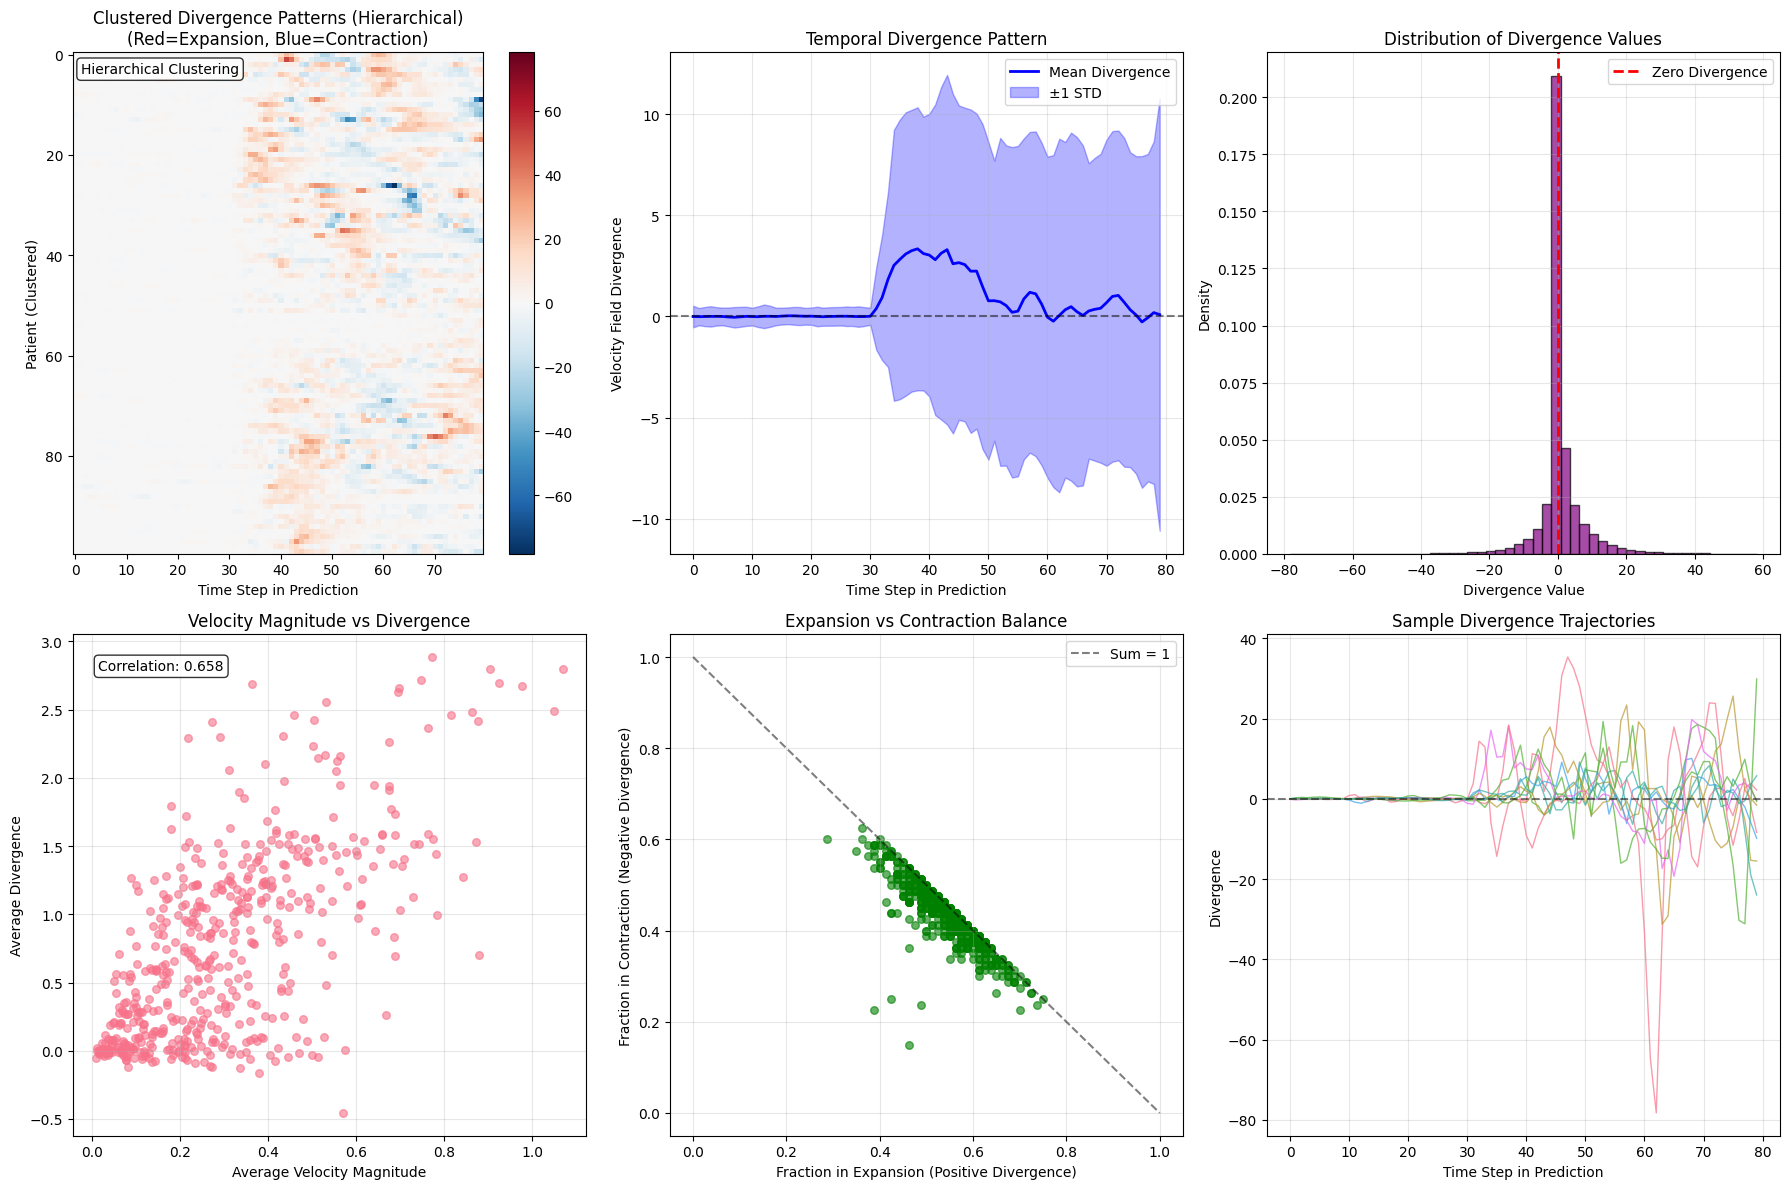

\nPhysical Interpretation of Divergence Analysis:
• Positive divergence indicates the velocity field is EXPANDING
  - Flow is spreading out from that point
  - May represent unstable or transitional physiological states
  - Could indicate model uncertainty or complex dynamics

• Negative divergence indicates the velocity field is CONTRACTING
  - Flow is converging toward that point
  - May represent stable or attractor-like physiological states
  - Could indicate model confidence and predictable patterns

• Zero divergence indicates volume-preserving flow
  - Flow is neither expanding nor contracting
  - May represent equilibrium or steady-state conditions


In [14]:
# Run Velocity Field Divergence Analysis at T=0

print("Computing velocity field divergence at T=0 (data state)...")
print("=" * 60)

# Compute divergence of velocity field at T=0
divergence_map, velocity_at_t0, clinical_features_div = compute_velocity_field_divergence_at_t0(
    flow_matching_model, new_test_batch, device, spatial_step=0.01, feature_step=0.01
)

print(f"\nDivergence computation completed!")
print(f"Divergence map shape: {divergence_map.shape}")
print(f"Velocity at T=0 shape: {velocity_at_t0.shape}")

# Analyze divergence patterns
divergence_summary = analyze_divergence_patterns(divergence_map, velocity_at_t0, clinical_features_div)

# Create visualizations
plot_divergence_analysis(divergence_map, velocity_at_t0, divergence_summary)


In [15]:
# Correlation Analysis: Divergence vs Clinical Features

def analyze_divergence_clinical_correlations(divergence_map, clinical_features):
    """Analyze correlations between velocity field divergence sign/magnitude and clinical outcomes."""
    
    # Focus on divergence sign and magnitude (not temporal variance)
    avg_divergence = divergence_map.mean(axis=1)  # Average divergence across time (positive/negative/zero)
    abs_divergence = np.abs(divergence_map).mean(axis=1)  # Average absolute divergence magnitude
    
    # Fraction of time points with positive vs negative divergence per patient
    fraction_positive = (divergence_map > 0).mean(axis=1)  # Fraction of expansion points
    fraction_negative = (divergence_map < 0).mean(axis=1)  # Fraction of contraction points
    
    # Clinical features to analyze
    clinical_vars = ['hr_mean', 'hr_std', 'hr_max', 'steps_total', 'steps_mean', 'steps_active_periods',
                     'food_events', 'food_total', 'glucose_mean', 'glucose_std', 'glucose_range']
    
    # Add covariate features if available
    if 'hba1c' in clinical_features:
        clinical_vars.extend(['age', 'diabetes_onset', 'weight', 'hba1c', 'height', 'bmi'])
    
    correlations = {}
    
    print("Correlation Analysis: Velocity Field Divergence (Expansion/Contraction) vs Clinical Features")
    print("=" * 80)
    print("Measures:")
    print("  • avg_divergence: Mean divergence (positive=expansion, negative=contraction)")
    print("  • abs_divergence: Mean absolute divergence magnitude")
    print("  • fraction_positive: Fraction of time spent in expansion regions")
    print("=" * 80)
    
    for var in clinical_vars:
        if var in clinical_features:
            # Remove any invalid values
            mask = ~(np.isnan(clinical_features[var]) | np.isinf(clinical_features[var]) | 
                    np.isnan(avg_divergence) | np.isinf(avg_divergence))
            
            if np.sum(mask) > 10:  # Need at least 10 valid samples
                # Correlations with different divergence measures
                corr_avg, p_avg = stats.pearsonr(avg_divergence[mask], clinical_features[var][mask])
                corr_abs, p_abs = stats.pearsonr(abs_divergence[mask], clinical_features[var][mask])
                corr_pos, p_pos = stats.pearsonr(fraction_positive[mask], clinical_features[var][mask])
                
                correlations[var] = {
                    'avg_divergence': {'correlation': corr_avg, 'p_value': p_avg},
                    'abs_divergence': {'correlation': corr_abs, 'p_value': p_abs},
                    'fraction_positive': {'correlation': corr_pos, 'p_value': p_pos}
                }
                
                # Display strongest correlation
                strongest_corr = max([(corr_avg, p_avg, 'avg'), (corr_abs, p_abs, 'abs'), (corr_pos, p_pos, 'pos')], 
                                   key=lambda x: abs(x[0]))
                
                significance = "***" if strongest_corr[1] < 0.001 else "**" if strongest_corr[1] < 0.01 else "*" if strongest_corr[1] < 0.05 else ""
                print(f"{var:20s}: r = {strongest_corr[0]:6.3f}, p = {strongest_corr[1]:.4f} {significance} ({strongest_corr[2]})")
            else:
                print(f"{var:20s}: Insufficient valid data")
    
    return correlations, {
        'avg_divergence': avg_divergence, 
        'abs_divergence': abs_divergence, 
        'fraction_positive': fraction_positive,
        'fraction_negative': fraction_negative
    }

# Run correlation analysis
print("\\nAnalyzing correlations between divergence and clinical features...")
divergence_correlations, divergence_measures = analyze_divergence_clinical_correlations(divergence_map, clinical_features_div)

# Summary of key findings
print("\\n" + "="*80)
print("SUMMARY: Velocity Field Divergence Analysis at T=0")
print("="*80)

print(f"\\n1. DIVERGENCE STATISTICS:")
print(f"   • Mean divergence: {divergence_map.mean():.6f}")
print(f"   • Standard deviation: {divergence_map.std():.6f}")
print(f"   • Range: [{divergence_map.min():.6f}, {divergence_map.max():.6f}]")

print(f"\\n2. FLOW FIELD INTERPRETATION:")
expansion_points = (divergence_map > 0).sum()
contraction_points = (divergence_map < 0).sum()
neutral_points = (np.abs(divergence_map) < 1e-6).sum()

print(f"   • Expansion regions: {expansion_points} points ({100*expansion_points/divergence_map.size:.1f}%)")
print(f"   • Contraction regions: {contraction_points} points ({100*contraction_points/divergence_map.size:.1f}%)")
print(f"   • Near-equilibrium regions: {neutral_points} points ({100*neutral_points/divergence_map.size:.1f}%)")

print(f"\\n3. CLINICAL CORRELATIONS:")
significant_correlations = []
for var, corr_data in divergence_correlations.items():
    for div_type, corr_info in corr_data.items():
        if corr_info['p_value'] < 0.05:
            significant_correlations.append((var, div_type, corr_info['correlation'], corr_info['p_value']))

significant_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

if significant_correlations:
    print(f"   • Found {len(significant_correlations)} significant correlations (p < 0.05):")
    for var, div_type, corr, p_val in significant_correlations[:5]:  # Top 5
        print(f"     - {var} vs {div_type}: r = {corr:.3f}, p = {p_val:.4f}")
else:
    print(f"   • No significant correlations found (p < 0.05)")

print(f"\\n4. EXPANSION vs CONTRACTION PATTERNS:")
avg_expansion_fraction = divergence_measures['fraction_positive'].mean()
avg_contraction_fraction = divergence_measures['fraction_negative'].mean()
print(f"   • Average fraction in expansion: {avg_expansion_fraction:.3f}")
print(f"   • Average fraction in contraction: {avg_contraction_fraction:.3f}")

print(f"\\n5. PHYSIOLOGICAL INTERPRETATION:")
print(f"   • POSITIVE divergence = flow EXPANSION (glucose dynamics spreading out)")
print(f"   • NEGATIVE divergence = flow CONTRACTION (glucose dynamics converging)")
print(f"   • HIGH absolute divergence = complex, hard-to-predict glucose patterns")
print(f"   • LOW absolute divergence = stable, predictable glucose control")


\nAnalyzing correlations between divergence and clinical features...
Correlation Analysis: Velocity Field Divergence (Expansion/Contraction) vs Clinical Features
Measures:
  • avg_divergence: Mean divergence (positive=expansion, negative=contraction)
  • abs_divergence: Mean absolute divergence magnitude
  • fraction_positive: Fraction of time spent in expansion regions
hr_mean             : r =  0.280, p = 0.0000 *** (abs)
hr_std              : r =  0.211, p = 0.0000 *** (abs)
hr_max              : r =  0.211, p = 0.0000 *** (abs)
steps_total         : r =  0.266, p = 0.0000 *** (abs)
steps_mean          : r =  0.266, p = 0.0000 *** (abs)
steps_active_periods: r =  0.336, p = 0.0000 *** (abs)
food_events         : r =  0.219, p = 0.0000 *** (abs)
food_total          : r =  0.234, p = 0.0000 *** (abs)
glucose_mean        : r =  0.206, p = 0.0000 *** (avg)
glucose_std         : r =  0.236, p = 0.0000 *** (abs)
glucose_range       : r =  0.271, p = 0.0000 *** (abs)
age                 : 

K-means clustering function defined!
\n============================================================
CLUSTERING ANALYSIS: Grouping Patients by Divergence Patterns


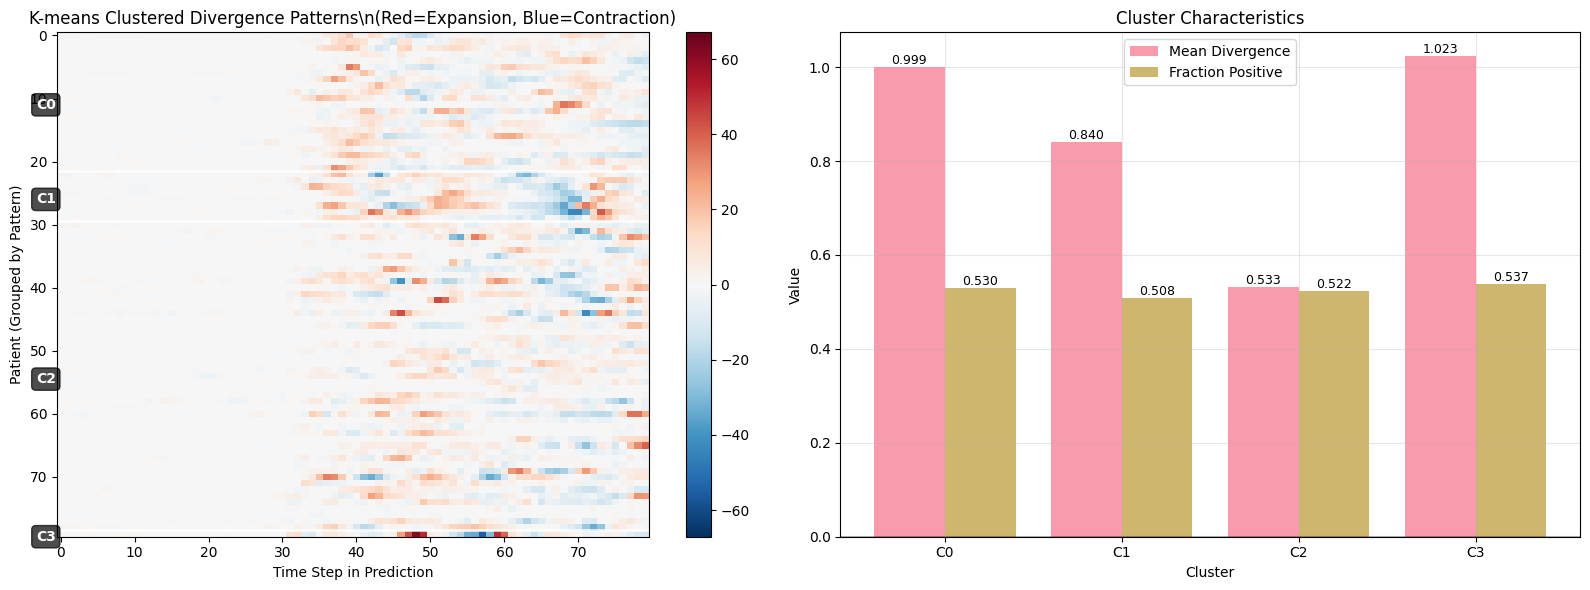

\nCluster Analysis Results:
Cluster 0 (EXPANSION-DOMINANT):
  • 22 patients
  • Mean divergence: 0.999321
  • Fraction in expansion: 0.530
  • Mean absolute divergence: 3.119400

Cluster 1 (EXPANSION-DOMINANT):
  • 8 patients
  • Mean divergence: 0.840281
  • Fraction in expansion: 0.508
  • Mean absolute divergence: 5.385839

Cluster 2 (EXPANSION-DOMINANT):
  • 49 patients
  • Mean divergence: 0.532629
  • Fraction in expansion: 0.522
  • Mean absolute divergence: 2.838542

Cluster 3 (EXPANSION-DOMINANT):
  • 1 patients
  • Mean divergence: 1.022840
  • Fraction in expansion: 0.537
  • Mean absolute divergence: 8.292205



In [31]:
# Add a K-means clustered heatmap as well
def plot_kmeans_clustered_heatmap(divergence_map):
    """
    Create a separate plot showing K-means clustered divergence patterns.
    """
    from sklearn.cluster import KMeans
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Use subset of data for cleaner visualization
    n_plot_samples = min(80, divergence_map.shape[0])
    divergence_subset = divergence_map[:n_plot_samples]
    
    # K-means clustering
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(divergence_subset)
    
    # Sort by cluster labels
    cluster_sort_idx = np.argsort(cluster_labels)
    divergence_sorted = divergence_subset[cluster_sort_idx]
    cluster_labels_sorted = cluster_labels[cluster_sort_idx]
    
    # Plot 1: K-means clustered heatmap
    im1 = axes[0].imshow(divergence_sorted, aspect='auto', cmap='RdBu_r', 
                        interpolation='nearest', vmin=-np.abs(divergence_map).max(), 
                        vmax=np.abs(divergence_map).max())
    axes[0].set_title('K-means Clustered Divergence Patterns\\n(Red=Expansion, Blue=Contraction)')
    axes[0].set_xlabel('Time Step in Prediction')
    axes[0].set_ylabel('Patient (Grouped by Pattern)')
    
    # Add cluster boundaries
    cluster_boundaries = []
    current_cluster = cluster_labels_sorted[0]
    for i, label in enumerate(cluster_labels_sorted):
        if label != current_cluster:
            cluster_boundaries.append(i - 0.5)
            current_cluster = label
    
    for boundary in cluster_boundaries:
        axes[0].axhline(y=boundary, color='white', linewidth=2, alpha=0.8)
    
    # Add cluster labels
    cluster_centers = []
    start_idx = 0
    for boundary in cluster_boundaries + [len(cluster_labels_sorted)]:
        end_idx = int(boundary + 0.5) if boundary != len(cluster_labels_sorted) else len(cluster_labels_sorted)
        center = (start_idx + end_idx) / 2
        cluster_centers.append(center)
        start_idx = end_idx
    
    for i, center in enumerate(cluster_centers):
        axes[0].text(-2, center, f'C{i}', ha='center', va='center', 
                    fontweight='bold', color='white',
                    bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    plt.colorbar(im1, ax=axes[0])
    
    # Plot 2: Cluster characteristics
    cluster_stats = []
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        cluster_data = divergence_subset[mask]
        
        stats = {
            'cluster': cluster_id,
            'n_patients': mask.sum(),
            'mean_divergence': cluster_data.mean(),
            'mean_abs_divergence': np.abs(cluster_data).mean(),
            'fraction_positive': (cluster_data > 0).mean(),
            'std_divergence': cluster_data.std()
        }
        cluster_stats.append(stats)
    
    # Bar plot of cluster characteristics
    cluster_ids = [s['cluster'] for s in cluster_stats]
    mean_divs = [s['mean_divergence'] for s in cluster_stats]
    pos_fractions = [s['fraction_positive'] for s in cluster_stats]
    
    ax2 = axes[1]
    x_pos = np.arange(len(cluster_ids))
    
    bars1 = ax2.bar(x_pos - 0.2, mean_divs, 0.4, label='Mean Divergence', alpha=0.7)
    bars2 = ax2.bar(x_pos + 0.2, pos_fractions, 0.4, label='Fraction Positive', alpha=0.7)
    
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Value')
    ax2.set_title('Cluster Characteristics')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'C{i}' for i in cluster_ids])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax2.text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{height1:.3f}', ha='center', va='bottom' if height1 >= 0 else 'top', fontsize=9)
        ax2.text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{height2:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print cluster interpretation
    print("\\nCluster Analysis Results:")
    print("=" * 50)
    for stats in cluster_stats:
        cluster_type = "EXPANSION-DOMINANT" if stats['mean_divergence'] > 0.001 else "CONTRACTION-DOMINANT" if stats['mean_divergence'] < -0.001 else "BALANCED"
        print(f"Cluster {stats['cluster']} ({cluster_type}):")
        print(f"  • {stats['n_patients']} patients")
        print(f"  • Mean divergence: {stats['mean_divergence']:.6f}")
        print(f"  • Fraction in expansion: {stats['fraction_positive']:.3f}")
        print(f"  • Mean absolute divergence: {stats['mean_abs_divergence']:.6f}")
        print()
    
    return cluster_labels, cluster_stats

print("K-means clustering function defined!")

# Run the clustering analysis
print("\\n" + "="*60)
print("CLUSTERING ANALYSIS: Grouping Patients by Divergence Patterns")
print("="*60)
cluster_labels, cluster_stats = plot_kmeans_clustered_heatmap(divergence_map)


In [28]:
# Analyze clinical characteristics of each divergence cluster
def analyze_cluster_clinical_profiles(cluster_labels, clinical_features, n_clusters=4):
    """
    Analyze clinical characteristics of each divergence pattern cluster.
    """
    print("\\nClinical Profiles of Divergence Clusters:")
    print("=" * 60)
    
    # Limit to subset that was clustered
    n_clustered = len(cluster_labels)
    
    # Clinical variables to analyze
    clinical_vars = ['hr_mean', 'glucose_mean', 'hba1c', 'food_events', 'bmi', 'age']
    
    cluster_profiles = {}
    
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        n_patients = mask.sum()
        
        print(f"\\nCluster {cluster_id} ({n_patients} patients):")
        print("-" * 40)
        
        cluster_profiles[cluster_id] = {}
        
        for var in clinical_vars:
            if var in clinical_features and len(clinical_features[var]) >= n_clustered:
                cluster_values = clinical_features[var][:n_clustered][mask]
                
                # Remove any invalid values
                valid_mask = ~(np.isnan(cluster_values) | np.isinf(cluster_values))
                if valid_mask.sum() > 0:
                    cluster_values_clean = cluster_values[valid_mask]
                    mean_val = cluster_values_clean.mean()
                    std_val = cluster_values_clean.std()
                    
                    cluster_profiles[cluster_id][var] = {
                        'mean': mean_val,
                        'std': std_val,
                        'n_valid': valid_mask.sum()
                    }
                    
                    print(f"  {var:15s}: {mean_val:7.2f} ± {std_val:5.2f} (n={valid_mask.sum()})")
                else:
                    print(f"  {var:15s}: No valid data")
    
    # Compare clusters statistically
    print(f"\\n\\nStatistical Comparison Between Clusters:")
    print("=" * 60)
    
    from scipy.stats import f_oneway
    
    for var in clinical_vars:
        if var in clinical_features and len(clinical_features[var]) >= n_clustered:
            cluster_groups = []
            for cluster_id in range(n_clusters):
                mask = cluster_labels == cluster_id
                cluster_values = clinical_features[var][:n_clustered][mask]
                valid_mask = ~(np.isnan(cluster_values) | np.isinf(cluster_values))
                if valid_mask.sum() > 2:  # Need at least 3 values for stats
                    cluster_groups.append(cluster_values[valid_mask])
            
            if len(cluster_groups) >= 2:
                try:
                    f_stat, p_value = f_oneway(*cluster_groups)
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    print(f"{var:15s}: F={f_stat:6.2f}, p={p_value:.4f} {significance}")
                except:
                    print(f"{var:15s}: Statistical test failed")
    
    return cluster_profiles

# Run clinical cluster analysis
if 'cluster_labels' in globals() and 'clinical_features_div' in globals():
    cluster_clinical_profiles = analyze_cluster_clinical_profiles(
        cluster_labels, clinical_features_div, n_clusters=4
    )
    
    print(f"\\n\\nSUMMARY: Divergence Cluster Interpretation")
    print("=" * 60)
    print("Each cluster represents patients with similar velocity field divergence patterns:")
    print("• Expansion-dominant clusters may represent unstable glucose control")
    print("• Contraction-dominant clusters may represent stable glucose control") 
    print("• Clinical differences between clusters suggest physiological relevance")
    print("• Statistical significance indicates divergence patterns correlate with clinical state")
else:
    print("Cluster analysis needs to be run first!")


Cluster analysis needs to be run first!


In [19]:
# Temporal Divergence Analysis: First Quarter vs Last Quarter
%matplotlib inline
def analyze_temporal_divergence_vs_activity(divergence_map, clinical_features):
    """
    Analyze how divergence in different temporal periods correlates with physical activity.
    """
    print("Temporal Divergence vs Physical Activity Analysis")
    print("=" * 60)
    
    pred_len = divergence_map.shape[1]
    
    # Define temporal periods
    first_quarter_end = pred_len // 8
    last_quarter_start =  pred_len // 8 * 7
    
    print(f"Prediction length: {pred_len} time steps")
    print(f"First quarter: steps 0-{first_quarter_end-1}")
    print(f"Last quarter: steps {last_quarter_start}-{pred_len-1}")
    print(divergence_map.shape)
    # Calculate average divergence for each temporal period
    first_quarter_divergence = divergence_map[:, 31: 48].mean(axis=1)
    last_quarter_divergence = divergence_map[:, 70:].mean(axis=1)
    
    print(f"\\nFirst quarter divergence stats:")
    print(f"  Mean: {first_quarter_divergence.mean():.6f}")
    print(f"  Std: {first_quarter_divergence.std():.6f}")
    print(f"  Range: [{first_quarter_divergence.min():.6f}, {first_quarter_divergence.max():.6f}]")
    
    print(f"\\nLast quarter divergence stats:")
    print(f"  Mean: {last_quarter_divergence.mean():.6f}")
    print(f"  Std: {last_quarter_divergence.std():.6f}")
    print(f"  Range: [{last_quarter_divergence.min():.6f}, {last_quarter_divergence.max():.6f}]")
    
    # Get physical activity measures
    steps_active = clinical_features.get('steps_active_periods', np.zeros(len(first_quarter_divergence)))
    steps_total = clinical_features.get('steps_total', np.zeros(len(first_quarter_divergence)))
    steps_mean = clinical_features.get('steps_mean', np.zeros(len(first_quarter_divergence)))
    
    # Remove invalid values
    valid_mask = ~(np.isnan(steps_active) | np.isinf(steps_active) | 
                  np.isnan(first_quarter_divergence) | np.isinf(first_quarter_divergence) |
                  np.isnan(last_quarter_divergence) | np.isinf(last_quarter_divergence))
    
    if valid_mask.sum() < 10:
        print("Insufficient valid data for correlation analysis")
        return None
    
    # Apply mask
    steps_active_clean = steps_active[valid_mask]
    steps_total_clean = steps_total[valid_mask]
    steps_mean_clean = steps_mean[valid_mask]
    first_quarter_clean = first_quarter_divergence[valid_mask]
    last_quarter_clean = last_quarter_divergence[valid_mask]
    
    print(f"\\nUsing {valid_mask.sum()} patients with valid data")
    
    # Compute correlations
    from scipy.stats import pearsonr
    
    # First quarter correlations
    corr_first_active, p_first_active = pearsonr(first_quarter_clean, steps_active_clean)
    corr_first_total, p_first_total = pearsonr(first_quarter_clean, steps_total_clean)
    corr_first_mean, p_first_mean = pearsonr(first_quarter_clean, steps_mean_clean)
    
    # Last quarter correlations
    corr_last_active, p_last_active = pearsonr(last_quarter_clean, steps_active_clean)
    corr_last_total, p_last_total = pearsonr(last_quarter_clean, steps_total_clean)
    corr_last_mean, p_last_mean = pearsonr(last_quarter_clean, steps_mean_clean)
    
    print(f"\\nCorrelations with Physical Activity:")
    print(f"{'Measure':<20} {'First Quarter':<20} {'Last Quarter':<20}")
    print("-" * 62)
    
    def format_corr(r, p):
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        return f"r={r:6.3f}, p={p:.4f}{sig:3s}"
    
    print(f"{'Steps Active':<20} {format_corr(corr_first_active, p_first_active):<20} {format_corr(corr_last_active, p_last_active)}")
    print(f"{'Steps Total':<20} {format_corr(corr_first_total, p_first_total):<20} {format_corr(corr_last_total, p_last_total)}")
    print(f"{'Steps Mean':<20} {format_corr(corr_first_mean, p_first_mean):<20} {format_corr(corr_last_mean, p_last_mean)}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: First quarter divergence vs steps active
    axes[0, 0].scatter(steps_total_clean, first_quarter_clean, alpha=0.6, s=30, color='blue')
    axes[0, 0].set_xlabel('Steps Active Periods')
    axes[0, 0].set_ylabel('First Quarter Divergence')
    axes[0, 0].set_title(f'Early Prediction Divergence vs Activity\\nr = {corr_first_active:.3f}, p = {p_first_active:.4f}')
    
    # Add trend line
    z = np.polyfit(steps_total_clean, first_quarter_clean, 1)
    p = np.poly1d(z)
    axes[0, 0].plot(steps_total_clean, p(steps_total_clean), "r--", alpha=0.8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Last quarter divergence vs steps active
    axes[0, 1].scatter(steps_total_clean, last_quarter_clean, alpha=0.6, s=30, color='red')
    axes[0, 1].set_xlabel('Steps Active Periods')
    axes[0, 1].set_ylabel('Last Quarter Divergence')
    axes[0, 1].set_title(f'Late Prediction Divergence vs Activity\\nr = {corr_last_active:.3f}, p = {p_last_active:.4f}')
    
    # Add trend line
    z = np.polyfit(steps_total_clean, last_quarter_clean, 1)
    p = np.poly1d(z)
    axes[0, 1].plot(steps_total_clean, p(steps_total_clean), "r--", alpha=0.8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Comparison of correlations
    quarters = ['First Quarter\\n(Early Prediction)', 'Last Quarter\\n(Late Prediction)']
    correlations_active = [corr_first_active, corr_last_active]
    correlations_total = [corr_first_total, corr_last_total]
    
    x = np.arange(len(quarters))
    width = 0.35
    
    bars1 = axes[1, 0].bar(x - width/2, correlations_active, width, label='Steps Active', alpha=0.7, color='blue')
    bars2 = axes[1, 0].bar(x + width/2, correlations_total, width, label='Steps Total', alpha=0.7, color='green')
    
    axes[1, 0].set_ylabel('Correlation with Divergence')
    axes[1, 0].set_title('Temporal Comparison: Activity vs Divergence')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(quarters)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    # Plot 4: First vs Last quarter divergence scatter
    axes[1, 1].scatter(first_quarter_clean, last_quarter_clean, alpha=0.6, s=30, color='purple')
    axes[1, 1].set_xlabel('First Quarter Divergence')
    axes[1, 1].set_ylabel('Last Quarter Divergence')
    
    # Correlation between first and last quarter
    corr_temporal, p_temporal = pearsonr(first_quarter_clean, last_quarter_clean)
    axes[1, 1].set_title(f'Early vs Late Divergence\\nr = {corr_temporal:.3f}, p = {p_temporal:.4f}')
    
    # Add diagonal line and trend line
    min_val = min(first_quarter_clean.min(), last_quarter_clean.min())
    max_val = max(first_quarter_clean.max(), last_quarter_clean.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
    
    z = np.polyfit(first_quarter_clean, last_quarter_clean, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(first_quarter_clean, p(first_quarter_clean), "r--", alpha=0.8, label='Trend')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print(f"\\nInterpretation:")
    print(f"=" * 40)
    
    if abs(corr_first_active) > abs(corr_last_active):
        stronger_period = "EARLY prediction"
        stronger_corr = corr_first_active
    else:
        stronger_period = "LATE prediction"
        stronger_corr = corr_last_active
    
    print(f"• Stronger correlation with activity in {stronger_period} (r={stronger_corr:.3f})")
    
    if corr_first_active > 0 and corr_last_active > 0:
        print(f"• Higher activity → more flow expansion in both periods")
    elif corr_first_active < 0 and corr_last_active < 0:
        print(f"• Higher activity → more flow contraction in both periods")
    else:
        print(f"• Activity has opposite effects on early vs late divergence")
    
    print(f"• Early-late divergence correlation: r={corr_temporal:.3f}")
    if corr_temporal > 0.5:
        print(f"  → Patients maintain consistent divergence patterns over time")
    elif corr_temporal < 0:
        print(f"  → Patients show opposing early/late divergence patterns")
    else:
        print(f"  → Divergence patterns change substantially over prediction horizon")
    
    return {
        'first_quarter_divergence': first_quarter_clean,
        'last_quarter_divergence': last_quarter_clean,
        'steps_active': steps_active_clean,
        'correlations': {
            'first_vs_activity': (corr_first_active, p_first_active),
            'last_vs_activity': (corr_last_active, p_last_active),
            'temporal_consistency': (corr_temporal, p_temporal)
        }
    }

print("Temporal divergence analysis function defined!")


Temporal divergence analysis function defined!


\n================================================================================
TEMPORAL ANALYSIS: Early vs Late Divergence and Physical Activity
Temporal Divergence vs Physical Activity Analysis
Prediction length: 80 time steps
First quarter: steps 0-9
Last quarter: steps 70-79
(512, 80)
\nFirst quarter divergence stats:
  Mean: 2.564771
  Std: 2.676679
  Range: [-0.521277, 12.425558]
\nLast quarter divergence stats:
  Mean: 0.377589
  Std: 4.733887
  Range: [-17.044205, 16.146648]
\nUsing 512 patients with valid data
\nCorrelations with Physical Activity:
Measure              First Quarter        Last Quarter        
--------------------------------------------------------------
Steps Active         r= 0.275, p=0.0000*** r=-0.020, p=0.6585   
Steps Total          r= 0.215, p=0.0000*** r=-0.011, p=0.7962   
Steps Mean           r= 0.215, p=0.0000*** r=-0.011, p=0.7962   


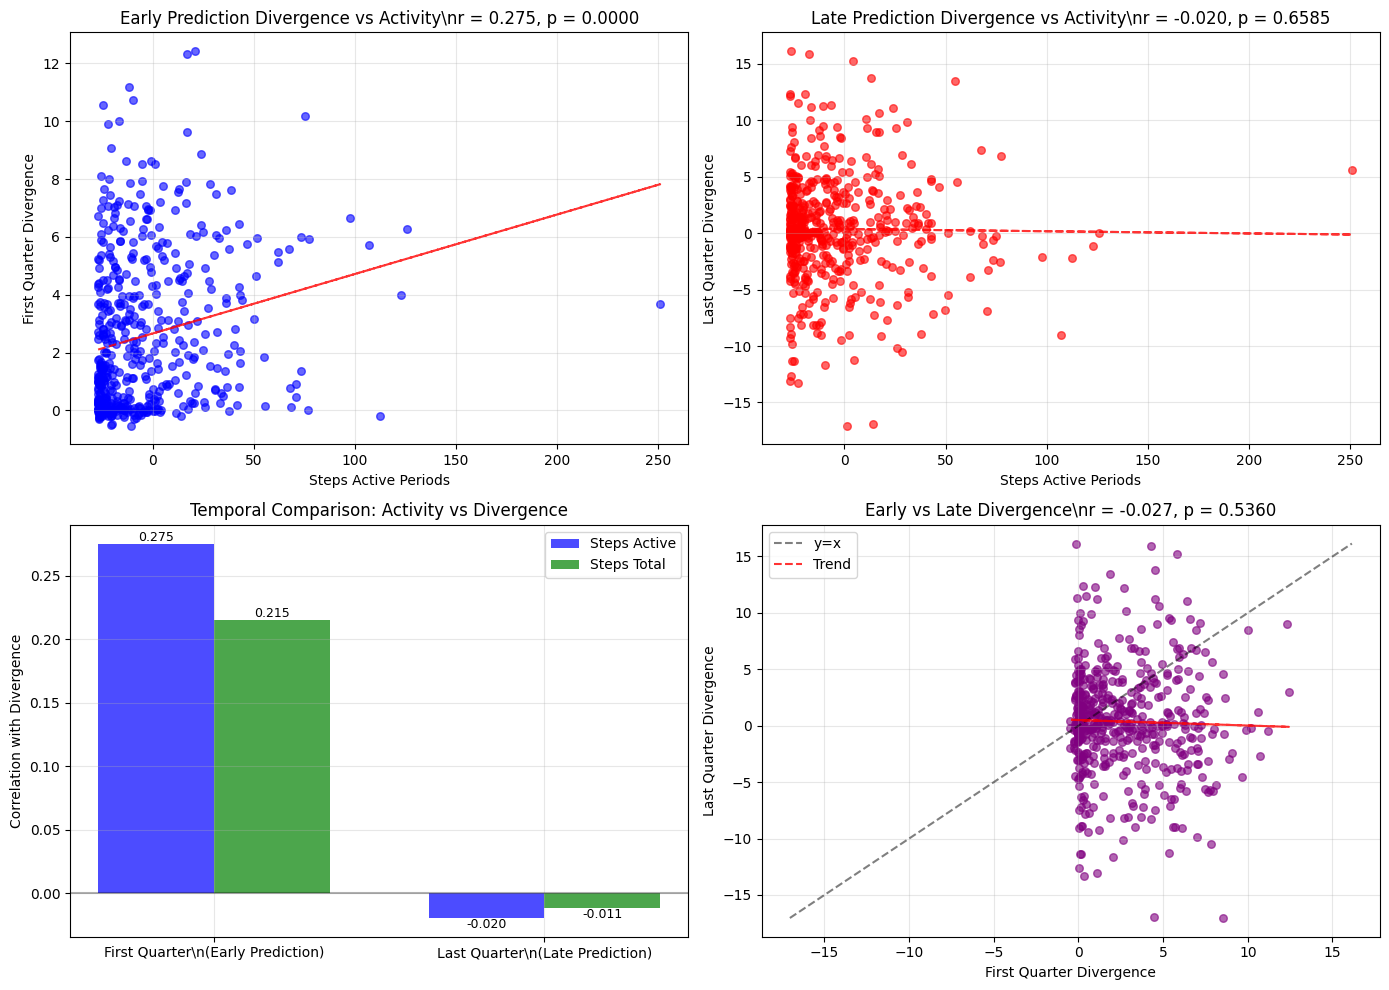

\nInterpretation:
• Stronger correlation with activity in EARLY prediction (r=0.275)
• Activity has opposite effects on early vs late divergence
• Early-late divergence correlation: r=-0.027
  → Patients show opposing early/late divergence patterns
\n\nKey Findings:
1. EARLY PREDICTION PERIOD:
   • Divergence-Activity correlation: r = 0.275, p = 0.0000
   • Significant: Higher activity → more flow expansion
\n2. LATE PREDICTION PERIOD:
   • Divergence-Activity correlation: r = -0.020, p = 0.6585
   • No significant correlation with activity
\n3. TEMPORAL CONSISTENCY:
   • Early-Late divergence correlation: r = -0.027, p = 0.5360
   • Low consistency: Divergence patterns change over time
\n4. CLINICAL IMPLICATIONS:
   • Physical activity has stronger impact on EARLY glucose dynamics
   • Model shows immediate response to activity levels
\n5. PHYSIOLOGICAL INTERPRETATION:
   • Early divergence: Immediate metabolic response patterns
   • Late divergence: Sustained/delayed metabolic adapta

In [20]:
# Run Temporal Divergence vs Activity Analysis

print("\\n" + "="*80)
print("TEMPORAL ANALYSIS: Early vs Late Divergence and Physical Activity")
print("="*80)

# Run the temporal analysis
temporal_results = analyze_temporal_divergence_vs_activity(divergence_map, clinical_features_div)

if temporal_results is not None:
    print(f"\\n\\nKey Findings:")
    print("=" * 50)
    
    first_corr, first_p = temporal_results['correlations']['first_vs_activity']
    last_corr, last_p = temporal_results['correlations']['last_vs_activity']
    temporal_corr, temporal_p = temporal_results['correlations']['temporal_consistency']
    
    print(f"1. EARLY PREDICTION PERIOD:")
    print(f"   • Divergence-Activity correlation: r = {first_corr:.3f}, p = {first_p:.4f}")
    if first_p < 0.05:
        direction = "expansion" if first_corr > 0 else "contraction"
        print(f"   • Significant: Higher activity → more flow {direction}")
    else:
        print(f"   • No significant correlation with activity")
    
    print(f"\\n2. LATE PREDICTION PERIOD:")
    print(f"   • Divergence-Activity correlation: r = {last_corr:.3f}, p = {last_p:.4f}")
    if last_p < 0.05:
        direction = "expansion" if last_corr > 0 else "contraction"
        print(f"   • Significant: Higher activity → more flow {direction}")
    else:
        print(f"   • No significant correlation with activity")
    
    print(f"\\n3. TEMPORAL CONSISTENCY:")
    print(f"   • Early-Late divergence correlation: r = {temporal_corr:.3f}, p = {temporal_p:.4f}")
    if temporal_corr > 0.7:
        print(f"   • Strong consistency: Patients maintain divergence patterns")
    elif temporal_corr > 0.3:
        print(f"   • Moderate consistency: Some pattern maintenance")
    elif temporal_corr > -0.3:
        print(f"   • Low consistency: Divergence patterns change over time")
    else:
        print(f"   • Opposing patterns: Early expansion → Late contraction (or vice versa)")
    
    print(f"\\n4. CLINICAL IMPLICATIONS:")
    if abs(first_corr) > abs(last_corr) and first_p < 0.05:
        print(f"   • Physical activity has stronger impact on EARLY glucose dynamics")
        print(f"   • Model shows immediate response to activity levels")
    elif abs(last_corr) > abs(first_corr) and last_p < 0.05:
        print(f"   • Physical activity has stronger impact on LATE glucose dynamics")
        print(f"   • Model shows delayed/sustained response to activity")
    elif first_p < 0.05 and last_p < 0.05:
        print(f"   • Physical activity affects glucose dynamics throughout prediction")
    else:
        print(f"   • Physical activity shows limited correlation with flow dynamics")
        
    print(f"\\n5. PHYSIOLOGICAL INTERPRETATION:")
    print(f"   • Early divergence: Immediate metabolic response patterns")
    print(f"   • Late divergence: Sustained/delayed metabolic adaptation")
    print(f"   • Activity correlation reveals how exercise affects glucose stability")
else:
    print("Analysis failed due to insufficient valid data")
